In [17]:
# -*- coding: utf-8 -*-
"""
ÌïòÎ£® Îã®ÏúÑ ‚Üí ÏãúÍ∞Ñ Îã®ÏúÑ(Ïãú/Ïä§ÏºÄÏ§Ñ Î∏îÎ°ù) Í≥µÏ†ï ÏãúÎÆ¨Î†àÏù¥ÏÖò (Ïùº/ÏãúÍ∞Ñ Ïä¨Î°Ø Î∂ÑÌï¥ Í∞ïÏ†ú)
- ÏûÖÎ†• CSV: subset_20240101_20250630_fullcols.csv (24-01-01 ~ 25-06-30 ÎÇ†Ïßú Ìè¨Ìï®)
- ÏûÖÎ†•Ïù¥ Ïù¥ÎØ∏ 'ÌïòÎ£® 1Ìñâ'Ïù¥Î©¥ ÏßëÍ≥ÑÎ•º Í±¥ÎÑàÎõ∞Í≥† Í≥ßÏû• Ïä¨Î°Ø Î∂ÑÌï¥
- Ï∂úÎ†•ÏùÄ ÎÇ†Ïßú√óÏä¨Î°Ø Í∞úÏàòÎßåÌÅº Ìñâ ÏÉùÏÑ± (QueueÎäî Little‚Äôs LawÎ°ú Í≥ÑÏÇ∞)

‚Äª ÌïòÎ£® Ï∞Ω: 07:50 ~ (Îã§ÏùåÎÇ†) 07:40
  - ÏûêÏ†ï Ïù¥ÌõÑ(00:00~07:40)Îäî ÏûêÎèôÏúºÎ°ú 'Îã§ÏùåÎÇ†'Î°ú Ï†ïÎ†¨Îê®
  - 20:10~20:40 Í≥µÎ∞±ÏùÄ 'Ìú¥Ïãù' Î∏îÎ°ùÏúºÎ°ú Ï±ÑÏõÄ
"""

import numpy as np
import pandas as pd

# =========================
# 1) CONFIG
# =========================
INPUT_CSV  = "./subset_20240101_20250630_fullcols.csv"
OUTPUT_CSV = "./FinalResults_time_scheduled_20240101_20250630.csv"
GRANULARITY = "hourly"  # "hourly" or "block"

# ‚ñº ÏÇ¨ÏßÑ Ïä§ÏºÄÏ§Ñ Î∞òÏòÅ + 20:10~20:40 ÍµêÎåÄ Ìú¥Ïãù Ï∂îÍ∞Ä
SCHEDULE_BLOCKS = [
    ("07:50", "09:50", "Ï£ºÍ∞Ñ"),
    ("09:50", "10:00", "Ìú¥Ïãù"),
    ("10:00", "11:50", "Ï£ºÍ∞Ñ"),
    ("11:50", "12:40", "Ï§ëÏãù"),
    ("12:40", "14:40", "Ï£ºÍ∞Ñ"),
    ("14:40", "14:50", "Ìú¥Ïãù"),
    ("14:50", "16:40", "Ï£ºÍ∞Ñ"),
    ("16:40", "17:10", "ÏÑùÏãù"),
    ("17:10", "20:10", "ÏûîÏóÖ"),
    ("20:10", "20:40", "Ìú¥Ïãù"),   # Í≥µÎ∞± Î≥¥Ï†ï(ÍµêÎåÄ 30Î∂Ñ)
    ("20:40", "00:00", "ÏïºÍ∞Ñ"),
    ("00:00", "00:30", "ÏïºÏãù"),   # Îã§ÏùåÎÇ†
    ("00:30", "04:00", "ÏïºÍ∞Ñ"),   # Îã§ÏùåÎÇ†
    ("04:00", "05:00", "Ìú¥Ïãù"),   # Îã§ÏùåÎÇ†
    ("05:00", "07:40", "ÏïºÍ∞Ñ"),   # Îã§ÏùåÎÇ†
]

# Í∑ºÎ¨¥¬∑Ìú¥Ïãù Î†àÏù¥Î∏îÎ≥Ñ Í∞ÄÏ§ëÏπò
SHIFT_WEIGHTS = {
    "Ï£ºÍ∞Ñ": 1.0,
    "ÏûîÏóÖ": 0.9,
    "ÏïºÍ∞Ñ": 1.2,
    "Ï§ëÏãù": 0.0,
    "ÏÑùÏãù": 0.0,
    "ÏïºÏãù": 0.0,
    "Ìú¥Ïãù": 0.0,
}

# Util/Time Î≥ÄÎèôÌè≠
UTIL_BAND = 0.15     # ¬±15%
TIME_BAND = 0.10     # ¬±10%


# =========================
# 2) HELPERS
# =========================
def to_dt(s):
    try:
        return pd.to_datetime(s, errors="coerce")
    except Exception:
        return pd.to_datetime(s.astype(str), errors="coerce")

def detect_date_col(df: pd.DataFrame) -> str:
    for c in ["Time_Now", "Timestamp", "timestamp", "Date", "date"]:
        if c in df.columns:
            return c
    return df.columns[0]

def day_floor(dt: pd.Series) -> pd.Series:
    return dt.dt.floor("D")

def aggregate_to_daily(df: pd.DataFrame, date_col: str):
    """Ïùº Îã®ÏúÑ ÏßëÍ≥Ñ: ÏÉùÏÇ∞Îüâ sum, ÏãúÍ∞Ñ/Ïú†Ìã∏/ÌÅê mean, Í∏∞ÌÉÄ first"""
    dt = to_dt(df[date_col])
    if dt.isna().all():
        raise ValueError(f"Could not parse datetime from '{date_col}'")
    df = df.copy()
    df["_date"] = day_floor(dt)

    count_cols = [c for c in df.columns if c.startswith("c_Cell") or c == "c_TotalProducts"]
    time_cols  = [c for c in df.columns if c.endswith("_Time")]
    util_cols  = [c for c in df.columns if c.endswith("_Util")]
    queue_cols = [c for c in df.columns if c.endswith("_Queue")]
    other_cols = sorted(set(df.columns) - set([date_col, "_date"] + count_cols + time_cols + util_cols + queue_cols))

    agg = {}
    for c in count_cols: agg[c] = "sum"
    for c in time_cols + util_cols + queue_cols: agg[c] = "mean"
    for c in other_cols: agg[c] = "first"

    daily = df.groupby("_date", as_index=False).agg(agg).sort_values("_date").reset_index(drop=True)
    daily[date_col] = daily["_date"]
    return daily.drop(columns=["_date"]), count_cols, time_cols, util_cols, queue_cols, date_col

def build_schedule_for_day(day: pd.Timestamp) -> pd.DataFrame:
    """
    'day'Ïùò Í∑ºÎ¨¥ÏùºÏùÑ 07:50 ~ (Îã§ÏùåÎÇ†) 07:40 ÏúºÎ°ú Ï†ïÏùòÌïòÍ≥†,
    SCHEDULE_BLOCKS(HH:MM)Î•º Ìï¥Îãπ ÏúàÎèÑÏóê ÎßûÍ≤å Ï†ïÎ†¨/ÌÅ¥Îû®ÌîÑÌïòÏó¨ Î∞òÌôò.
    - 07:50Î≥¥Îã§ Ïù¥Î•∏ HH:MMÏùÄ Î™®Îëê 'Îã§ÏùåÎÇ†'Î°ú Í∞ÑÏ£º(+1Ïùº)
    - ÏµúÏ¢Ö ÏúàÎèÑ Î∞ñ Íµ¨Í∞ÑÏùÄ ÏûòÎùºÎÉÑ
    """
    rows = []

    # ÌïòÎ£® Ï∞Ω Ï†ïÏùò: [07:50, Îã§ÏùåÎÇ† 07:40]
    anchor_start = pd.Timestamp(day.year, day.month, day.day, 7, 50)
    anchor_end   = pd.Timestamp(day.year, day.month, day.day, 7, 40) + pd.Timedelta(days=1)

    for start_str, end_str, label in SCHEDULE_BLOCKS:
        s_h, s_m = map(int, start_str.split(":"))
        e_h, e_m = map(int, end_str.split(":"))

        # ÏãúÏûë ÏãúÍ∞Å
        start = pd.Timestamp(day.year, day.month, day.day, s_h, s_m)
        if (s_h, s_m) < (7, 50):
            start += pd.Timedelta(days=1)  # Îã§ÏùåÎÇ†

        # Ï¢ÖÎ£å ÏãúÍ∞Å
        end = pd.Timestamp(day.year, day.month, day.day, e_h, e_m)
        if (e_h, e_m) < (7, 50) or end <= start:
            end += pd.Timedelta(days=1)  # Îã§ÏùåÎÇ† ÎòêÎäî ÏûêÏ†ï ÎûòÌïë

        # ÌïòÎ£® Ï∞ΩÏúºÎ°ú ÌÅ¥Îû®ÌîÑ
        s = max(start, anchor_start)
        e = min(end, anchor_end)
        if e <= s:
            continue

        minutes = int((e - s).total_seconds() // 60)
        rows.append({"start": s, "end": e, "label": label, "minutes": minutes})

    return pd.DataFrame(rows)

def explode_to_hours(sch: pd.DataFrame) -> pd.DataFrame:
    """Î∏îÎ°ù ‚Üí Ï†ïÏãú Ïä¨Î°Ø Î∂ÑÌï¥ + Í∞Å Ïä¨Î°ØÍ≥ºÏùò Í≤πÏπ® Î∂Ñ(min_overlap) Í≥ÑÏÇ∞"""
    t_min = sch["start"].min().floor("h")
    t_max = sch["end"].max().ceil("h")
    hours = pd.date_range(t_min, t_max, freq="h")
    slots = pd.DataFrame({"slot_start": hours[:-1], "slot_end": hours[1:]})

    out = []
    for _, blk in sch.iterrows():
        for _, sl in slots.iterrows():
            s = max(blk["start"], sl["slot_start"])
            e = min(blk["end"], sl["slot_end"])
            overlap = (e - s).total_seconds() / 60.0
            if overlap > 0:
                out.append({
                    "slot_start": sl["slot_start"],
                    "slot_end": sl["slot_end"],
                    "label": blk["label"],
                    "min_overlap": overlap
                })
    return pd.DataFrame(out)

def integer_allocate(total: float, weights: np.ndarray) -> np.ndarray:
    """Ï†ïÏàò Î∂ÑÎ∞∞(ÏûîÏ∞® Î≥¥Ï†ï)"""
    w = np.clip(np.asarray(weights, float), 0, None)
    if w.sum() <= 0 or total <= 0:
        return np.zeros_like(w, dtype=int)
    p = w / w.sum()
    alloc = np.floor(total * p).astype(int)
    residual = int(round(total - alloc.sum()))
    if residual > 0:
        idx = np.argsort(-p)[:residual]
        alloc[idx] += 1
    return alloc


# =========================
# 3) MAIN TRANSFORM
# =========================
def make_time_scheduled(df_daily: pd.DataFrame,
                        count_cols, time_cols, util_cols, queue_cols,
                        date_col: str,
                        granularity: str = "hourly") -> pd.DataFrame:
    rows = []

    # SKUÎ≥Ñ Wait Ïª¨Îüº Îß§Ìïë (Ïòà: "SKU3_Wait_Time")
    sku_wait_cols = {c.split("_")[0]: c for c in time_cols if c.startswith("SKU") and c.endswith("Wait_Time")}
    overall_wait_name = next((c for c in time_cols if c.endswith("Wait_Time")), None)

    for _, day_row in df_daily.iterrows():
        day = pd.to_datetime(day_row[date_col]).floor("D")
        sch = build_schedule_for_day(day)
        if sch.empty:
            continue

        if granularity == "block":
            slot_df = sch.rename(columns={"start":"slot_start","end":"slot_end"})
            slot_df["min_overlap"] = (slot_df["slot_end"] - slot_df["slot_start"]).dt.total_seconds()/60.0
            slot_df = slot_df[["slot_start","slot_end","label","min_overlap"]]
        else:
            slot_df = explode_to_hours(sch)

        # ÏÉùÏÇ∞ Í∞ÄÏ§ëÏπò
        slot_df["shift_weight"] = slot_df["label"].map(SHIFT_WEIGHTS).fillna(0.0)
        slot_df["work_minutes"] = slot_df["min_overlap"] * (slot_df["shift_weight"] > 0).astype(float)
        slot_df["prod_weight"] = slot_df["work_minutes"] * slot_df["shift_weight"]

        # count Î∂ÑÎ∞∞(Ï†ïÏàò)
        for c in count_cols:
            total = float(day_row[c])
            slot_df[c] = integer_allocate(total, slot_df["prod_weight"].values)

        # Util/Time Î∂ÑÎ∞∞
        safe_eps = 1e-12
        work_mask = slot_df["shift_weight"].values > 0
        sw = slot_df["shift_weight"].values.copy()
        if work_mask.any():
            sw_norm = np.zeros_like(sw, dtype=float)
            mean_sw = sw[work_mask].mean()
            sw_norm[work_mask] = sw[work_mask] / (mean_sw + safe_eps)
        else:
            sw_norm = np.zeros_like(sw, dtype=float)

        for c in util_cols:
            mean_u = float(day_row[c])
            u = np.zeros(len(slot_df), dtype=float)
            u[work_mask] = mean_u * (1.0 - UTIL_BAND + 2*UTIL_BAND * sw_norm[work_mask])
            slot_df[c] = np.clip(u, 0, 1)

        for c in time_cols:
            mean_t = float(day_row[c])
            t = np.zeros(len(slot_df), dtype=float)
            if mean_t != 0 and work_mask.any():
                t[work_mask] = mean_t * (1.0 - TIME_BAND + 2*TIME_BAND * sw_norm[work_mask])
            slot_df[c] = t

        # Queue(L = Œª√óW)
        slot_df["slot_seconds"] = (slot_df["slot_end"] - slot_df["slot_start"]).dt.total_seconds()
        per_slot_total = slot_df[count_cols].sum(axis=1).astype(float)
        lam = (per_slot_total / slot_df["slot_seconds"].replace(0, np.nan)).fillna(0.0)

        for qc in queue_cols:
            daily_mean_q = float(day_row[qc])

            # SKUx Îß§Ïπ≠
            sku_tag = next((p for p in qc.split("_") if p.startswith("SKU")), None)
            if sku_tag and sku_tag in sku_wait_cols:
                inferred_W = slot_df[sku_wait_cols[sku_tag]].astype(float)
            elif overall_wait_name is not None:
                inferred_W = slot_df[overall_wait_name].astype(float)
            else:
                inferred_W = pd.Series(np.zeros(len(slot_df)))

            L = lam * inferred_W
            if (L > 0).any():
                scale = (daily_mean_q / (L.mean() + 1e-9)) if daily_mean_q != 0 else 0.0
                q_vals = (L * scale).values
            else:
                w = slot_df["prod_weight"].values
                w = w / (w.sum() + 1e-9)
                q_vals = w * daily_mean_q * len(slot_df)
            slot_df[qc] = q_vals

        # Ï∂úÎ†• ÎàÑÏ†Å
        for _, r in slot_df.iterrows():
            out = {"Time_Now": r["slot_start"], "Time_End": r["slot_end"], "ShiftLabel": r["label"]}
            for c in count_cols + util_cols + time_cols + queue_cols:
                out[c] = r.get(c, 0)
            rows.append(out)

    result = pd.DataFrame(rows).sort_values(["Time_Now"]).reset_index(drop=True)

    # Ïª¨Îüº ÏàúÏÑú Ï†ïÎ¶¨
    keep_order, all_cols = [], set(count_cols + util_cols + time_cols + queue_cols)
    for c in df_daily.columns:
        if c in all_cols:
            keep_order.append(c)
    for c in (set(all_cols) - set(keep_order)):
        keep_order.append(c)
    result = result.reindex(columns=["Time_Now","Time_End","ShiftLabel"] + keep_order)
    return result


# =========================
# 4) RUN
# =========================
if __name__ == "__main__":
    # 1) Î°úÎìú
    full = pd.read_csv(INPUT_CSV, low_memory=False)

    # 2) ÎÇ†Ïßú Ïª¨Îüº ÌÉêÏßÄ Î∞è datetime Î≥ÄÌôò
    date_col = detect_date_col(full)
    full[date_col] = to_dt(full[date_col])
    if full[date_col].isna().all():
        raise ValueError(f"ÎÇ†Ïßú ÌååÏã± Ïã§Ìå®: '{date_col}' Ïª¨ÎüºÏùÑ datetimeÏúºÎ°ú Î≥ÄÌôòÌï† Ïàò ÏóÜÏäµÎãàÎã§.")
    full["_date"] = full[date_col].dt.floor("D")

    # 3) ÏûÖÎ†• ÌòïÌÉú ÌåêÎã®
    nunique_dates = full["_date"].nunique()
    is_daily_like = (len(full) == nunique_dates)

    # 4) Ïó¥ Í∑∏Î£πÌôî
    count_cols = [c for c in full.columns if c.startswith("c_Cell") or c == "c_TotalProducts"]
    time_cols  = [c for c in full.columns if c.endswith("_Time")]
    util_cols  = [c for c in full.columns if c.endswith("_Util")]
    queue_cols = [c for c in full.columns if c.endswith("_Queue")]

    # 5) Ïùº ÏßëÍ≥Ñ/Ïä§ÌÇµ
    if is_daily_like:
        df_daily = full.drop(columns=["_date"]).copy()
        df_daily[date_col] = full["_date"].values
    else:
        df_daily = full.drop(columns=["_date"]).copy()
        df_daily, count_cols, time_cols, util_cols, queue_cols, date_col = aggregate_to_daily(df_daily, date_col)

    # 6) ÏãúÍ∞ÑÌëú Í∏∞Î∞ò Î∂ÑÌï¥
    out = make_time_scheduled(
        df_daily,
        count_cols=count_cols,
        time_cols=time_cols,
        util_cols=util_cols,
        queue_cols=queue_cols,
        date_col=date_col,
        granularity=GRANULARITY,
    )

    # 7) Ï†ÄÏû• (Excel ÌïúÍ∏Ä Ïïà Íπ®ÏßÄÍ≤å)
    out.to_csv(OUTPUT_CSV, index=False, encoding="utf-8-sig")

    # 8) ÏßÑÎã® Î°úÍ∑∏
    sample_day = pd.to_datetime(df_daily[date_col].iloc[0])
    sample_slots = (explode_to_hours(build_schedule_for_day(sample_day))
                    if GRANULARITY == "hourly"
                    else build_schedule_for_day(sample_day))
    slots_per_day = len(sample_slots) if GRANULARITY == "hourly" else len(SCHEDULE_BLOCKS)

    print(f"[OK] Saved -> {OUTPUT_CSV}")
    print(f"ÏûÖÎ†• ÎÇ†Ïßú Ïàò: {nunique_dates:,} | ÎåÄÌëú ÌïòÎ£® Ïä¨Î°Ø Ïàò: {slots_per_day}")
    print(f"ÏòàÏÉÅ ÌñâÏàò ‚âà {nunique_dates * slots_per_day:,} | Ïã§Ï†ú ÌñâÏàò = {len(out):,}")

[OK] Saved -> ./FinalResults_time_scheduled_20240101_20250630.csv
ÏûÖÎ†• ÎÇ†Ïßú Ïàò: 547 | ÎåÄÌëú ÌïòÎ£® Ïä¨Î°Ø Ïàò: 35
ÏòàÏÉÅ ÌñâÏàò ‚âà 19,145 | Ïã§Ï†ú ÌñâÏàò = 19,145


In [19]:
import pandas as pd

# ÌååÏùº Í≤ΩÎ°ú
CSV_PATH = "./FinalResults_time_scheduled_20240101_20250630.csv"

# CSV Î∂àÎü¨Ïò§Í∏∞
df = pd.read_csv(CSV_PATH, low_memory=False)

# 'queue' (ÎåÄÏÜåÎ¨∏Ïûê Íµ¨Î∂Ñ X) Ìè¨Ìï®Îêú Ïª¨ÎüºÎßå Ï∂îÏ∂ú
queue_cols = [c for c in df.columns if "queue" in c.lower()]
print(f"Queue Í¥ÄÎ†® Ïª¨Îüº Ïàò: {len(queue_cols)}")
print(queue_cols)

# Í∑∏ Ïª¨ÎüºÎì§Îßå DataFrameÏúºÎ°ú Ï∂îÏ∂ú
df_queue = df[queue_cols]

# ÏïûÎ∂ÄÎ∂Ñ ÌôïÏù∏
#print(df_queue.head())

Queue Í¥ÄÎ†® Ïª¨Îüº Ïàò: 23
['Blanking_SKU1_Queue', 'Blanking_SKU2_Queue', 'Blanking_SKU3_Queue', 'Blanking_SKU4_Queue', 'Press1_Queue', 'Press2_Queue', 'Press3_Queue', 'Press4_Queue', 'Cell1_Queue', 'Cell2_Queue', 'Cell3_Queue', 'Cell4_Queue', 'Warehouse1_Queue', 'Warehouse_2_Queue', 'Warehouse_3_Queue', 'Warehouse_4_Queue', 'Paint1_Queue', 'Paint2_Queue', 'Quality_Queue', 'Forklift_Blanking_Queue', 'Forklift_Press_Queue', 'Forklift_Assembly_Queue', 'Blanking_Queue']


In [25]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Malgun Gothic'   # ÏúàÎèÑÏö∞ (ÎßëÏùÄ Í≥†Îîï)
mpl.rcParams['axes.unicode_minus'] = False      # ÎßàÏù¥ÎÑàÏä§ Í∏∞Ìò∏ Íπ®Ïßê Î∞©ÏßÄ

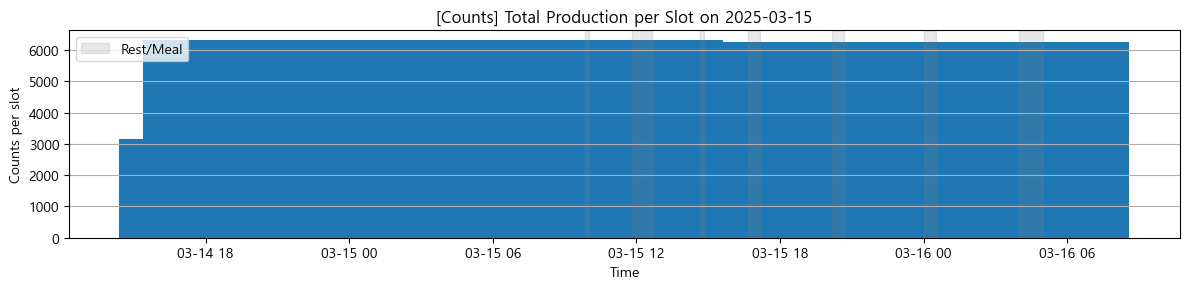

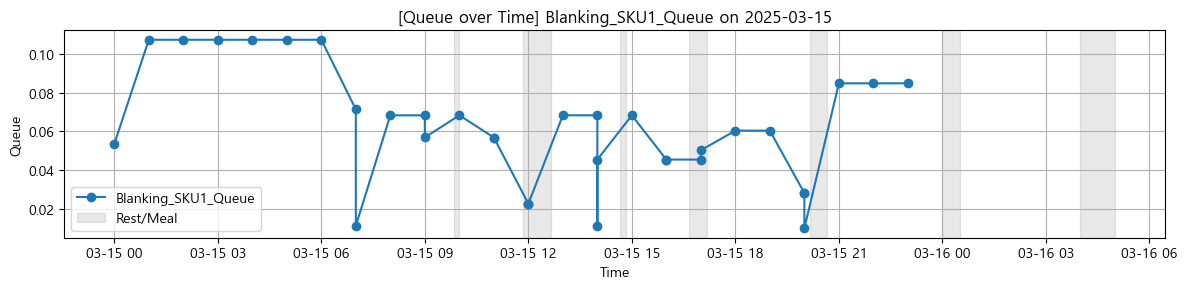

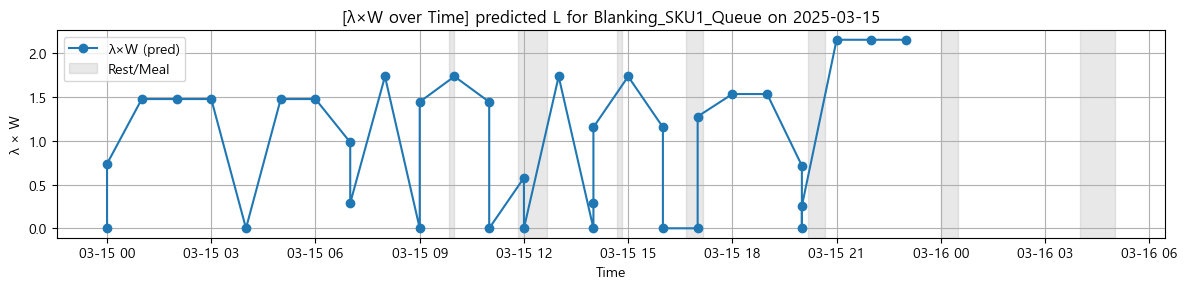

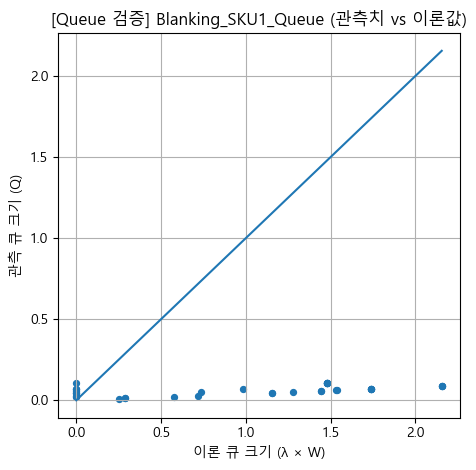

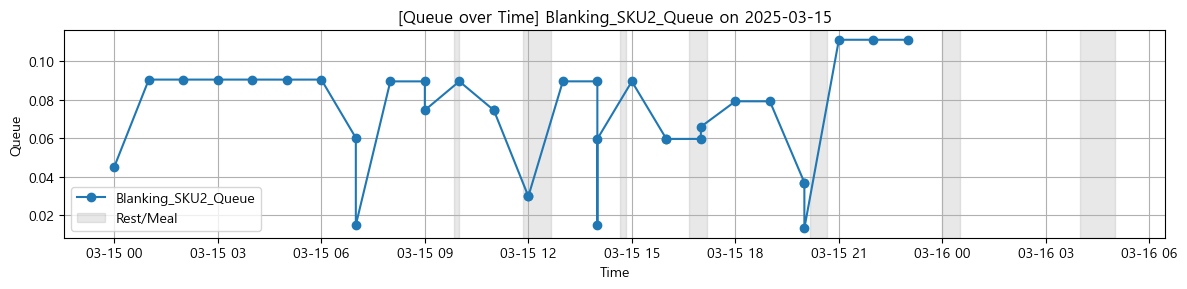

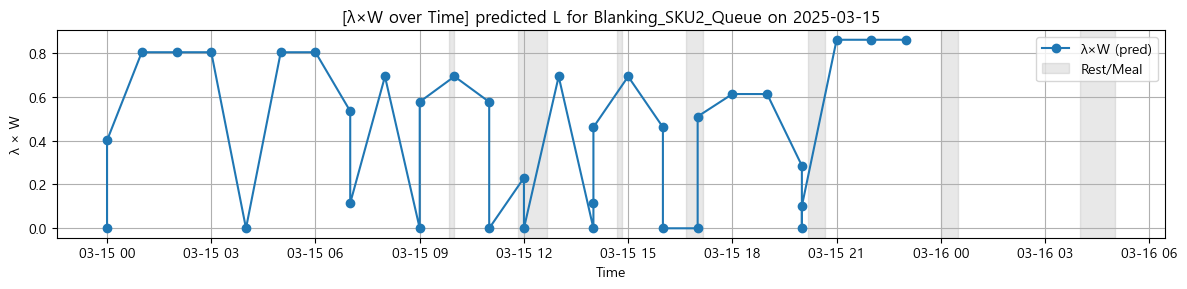

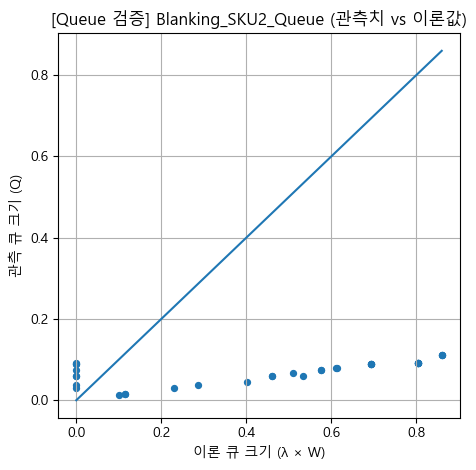

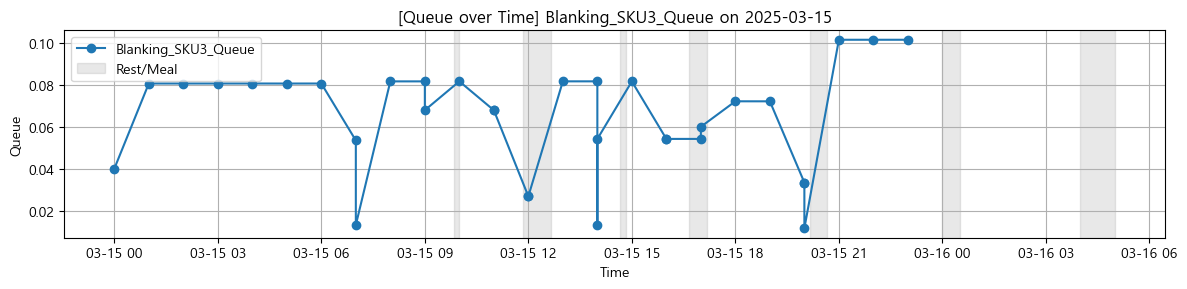

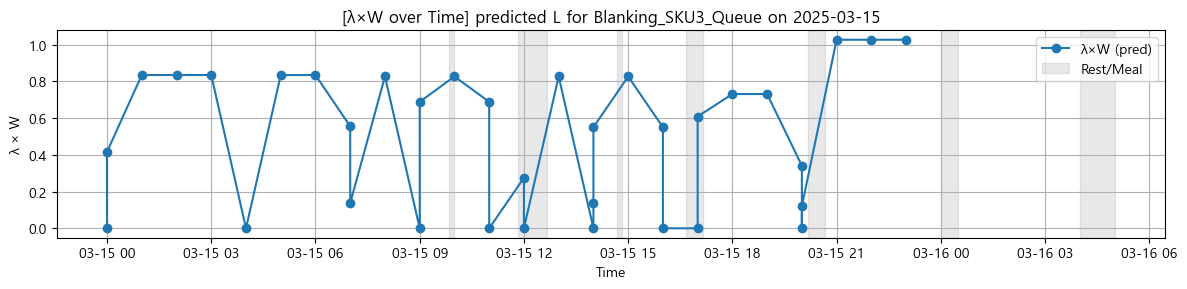

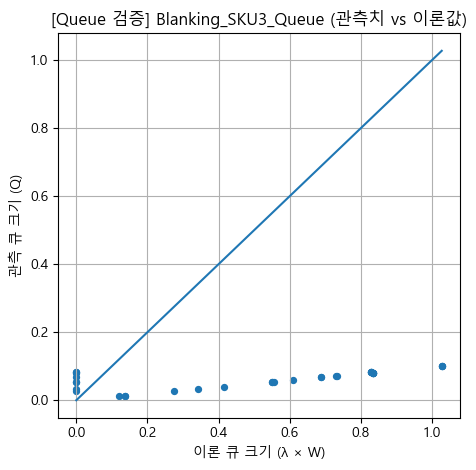

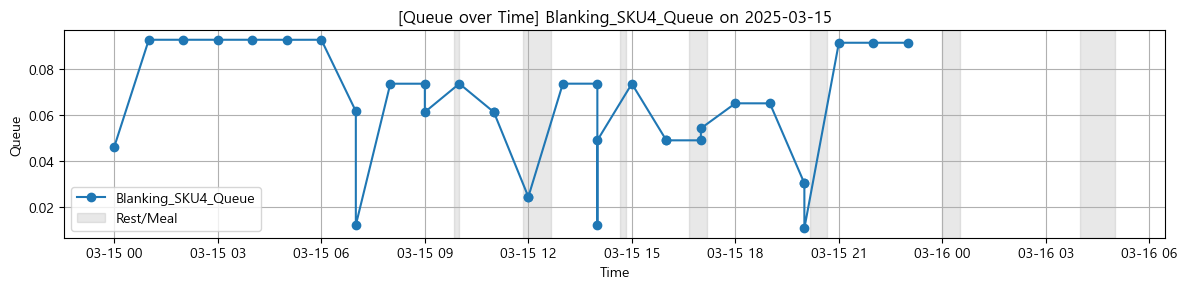

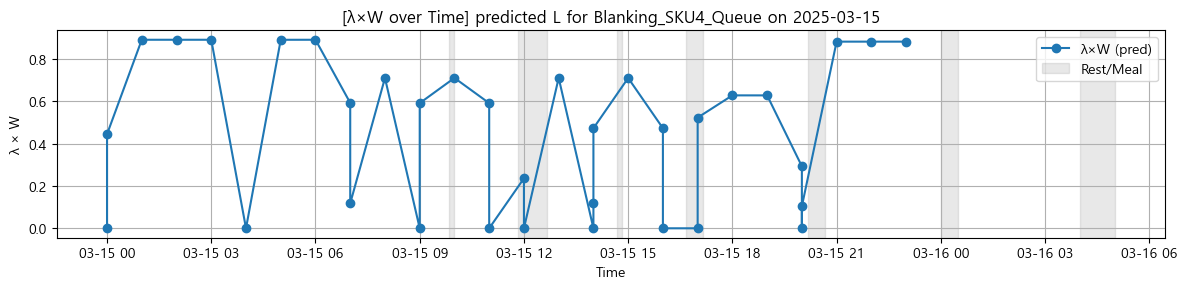

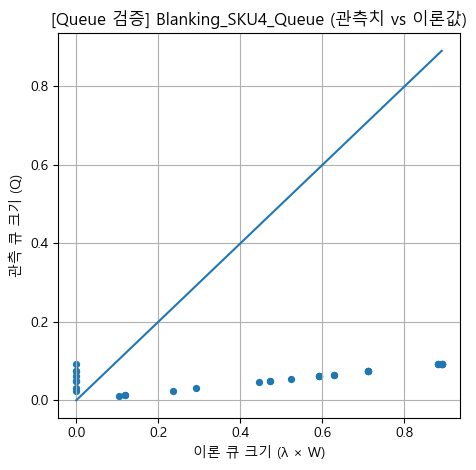

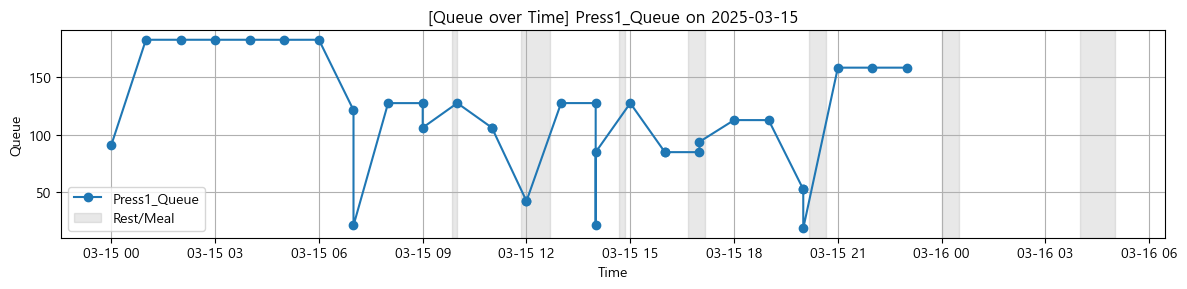

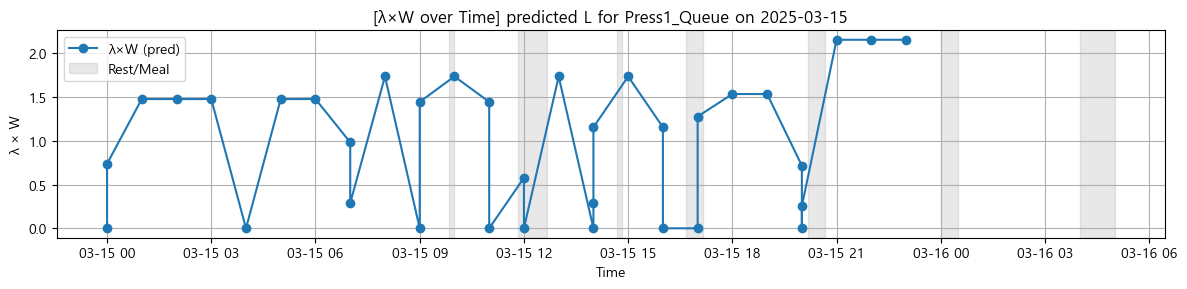

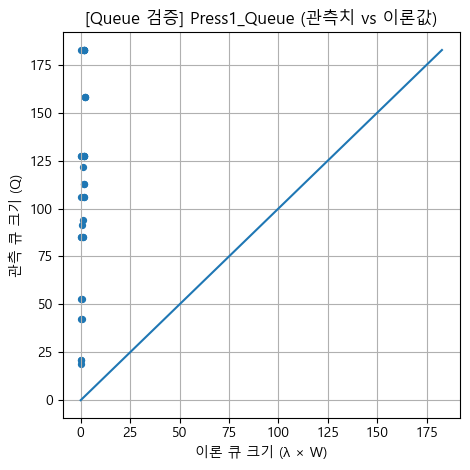

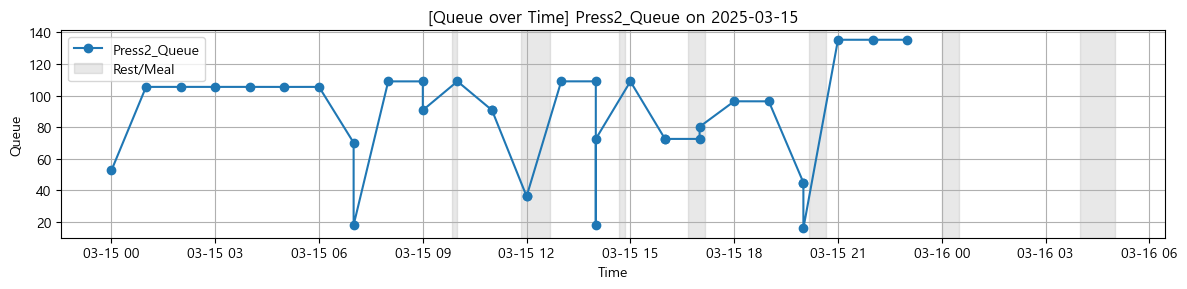

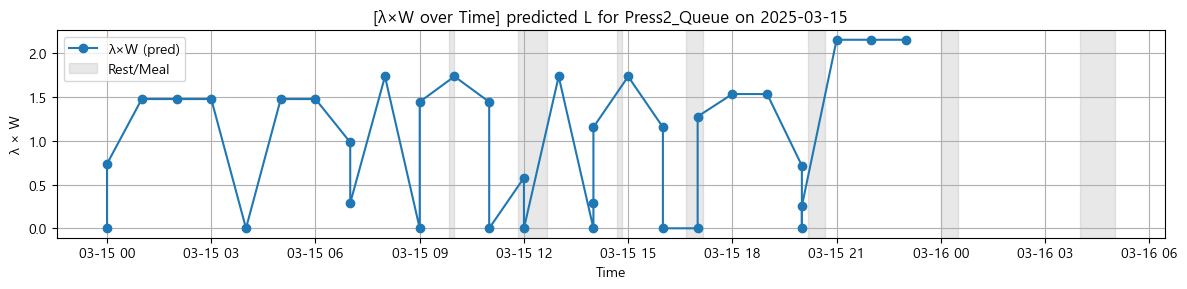

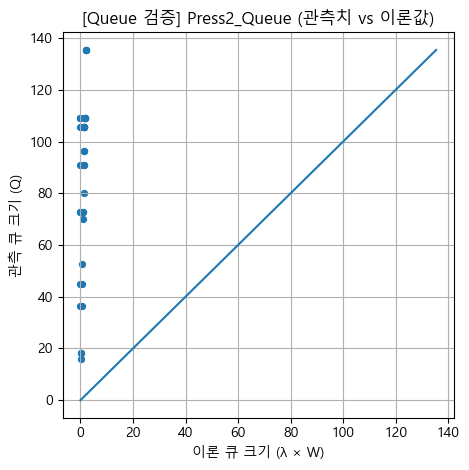

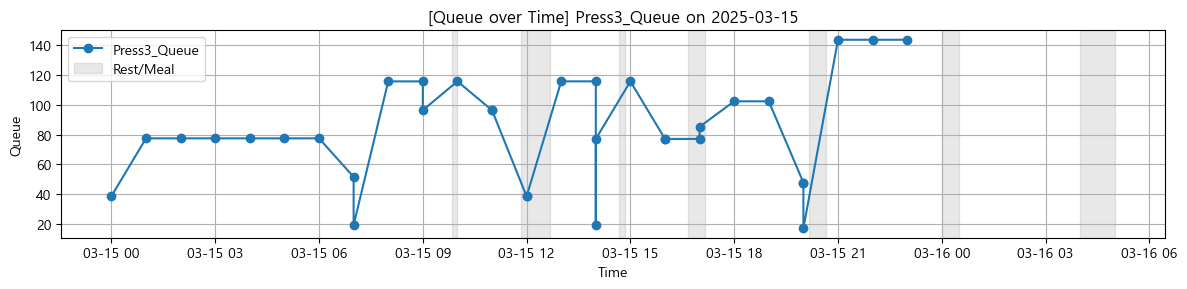

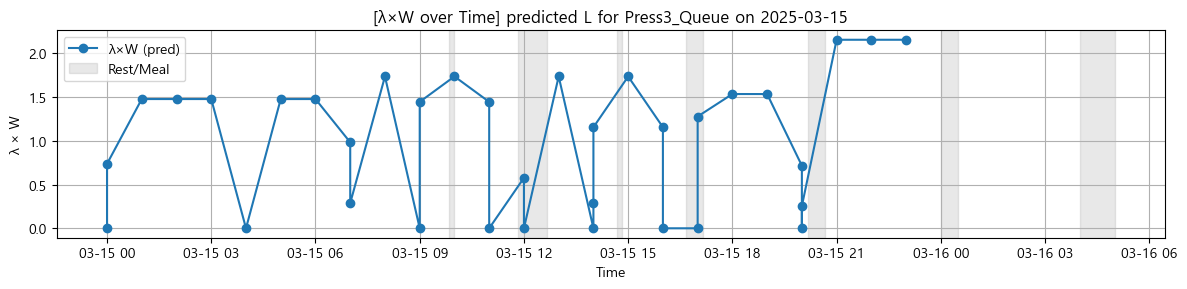

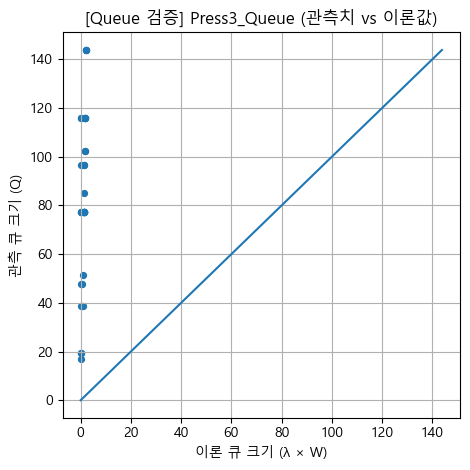

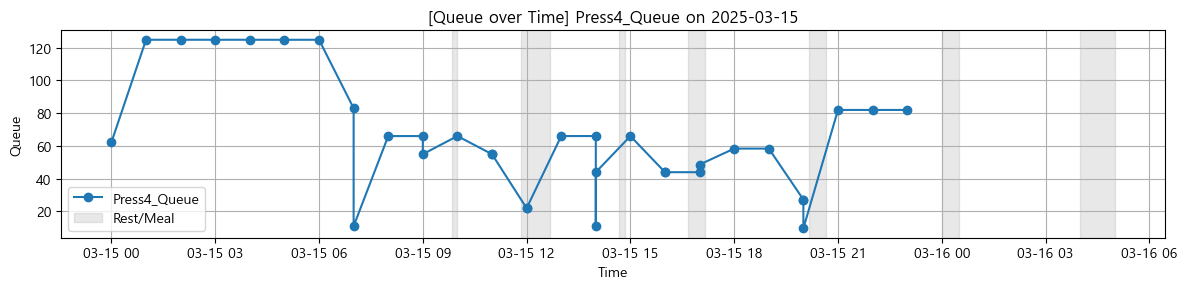

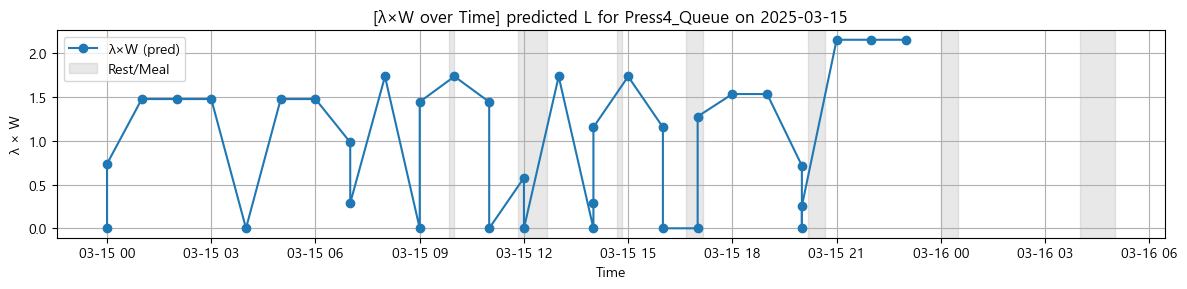

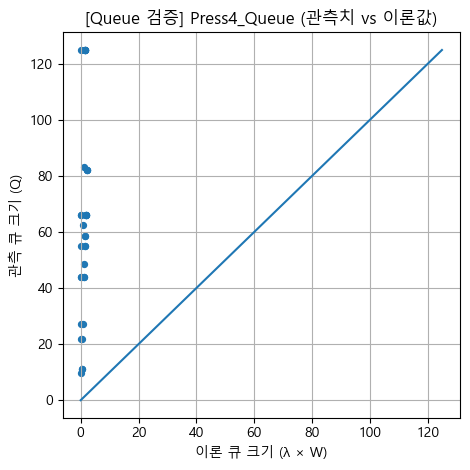

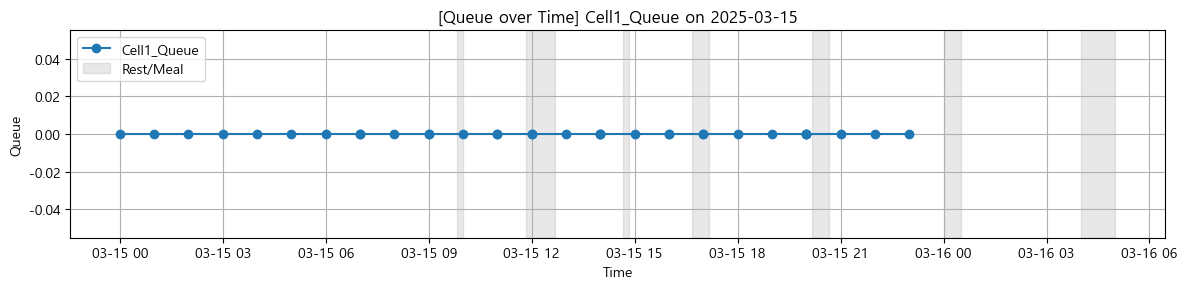

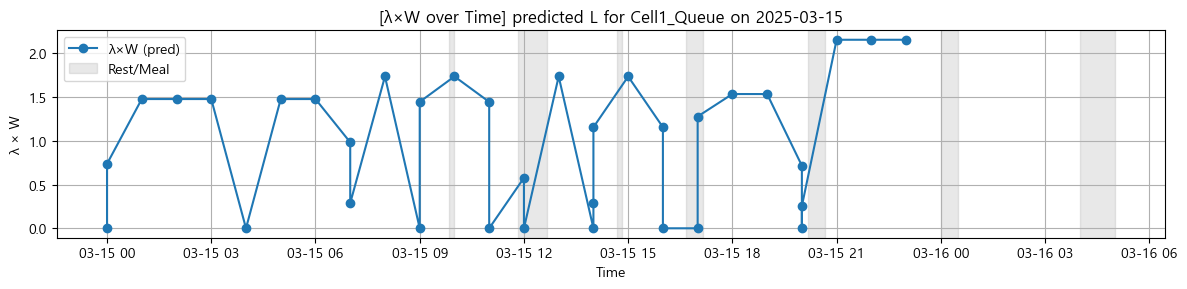

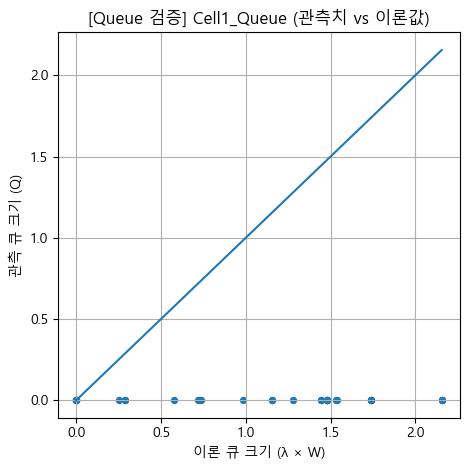

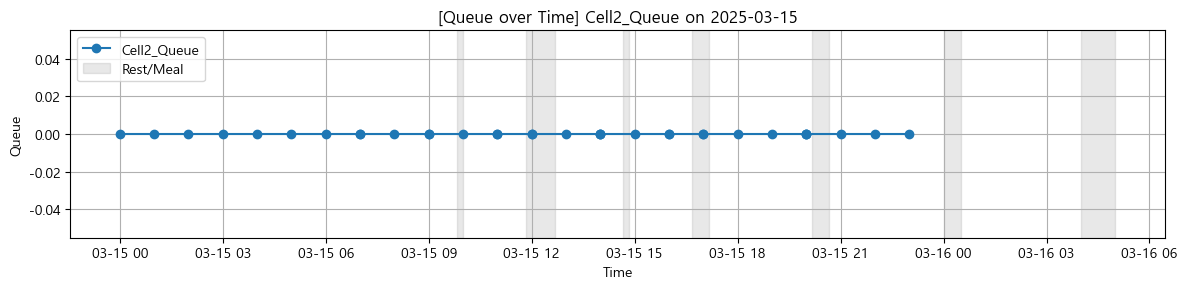

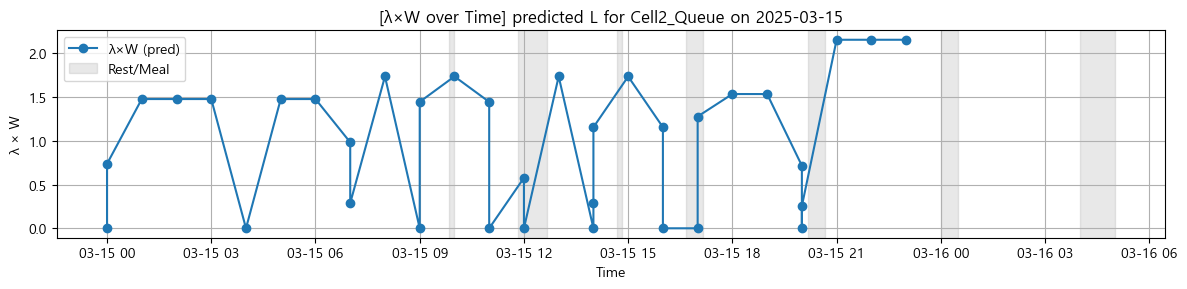

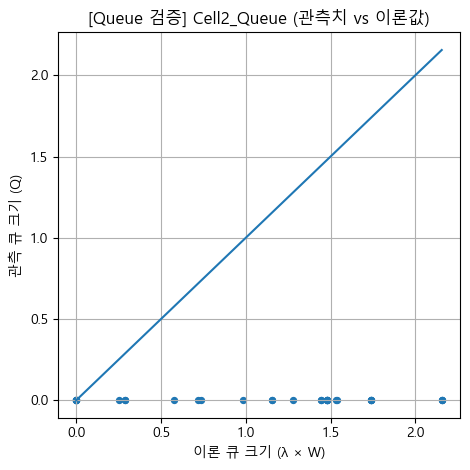

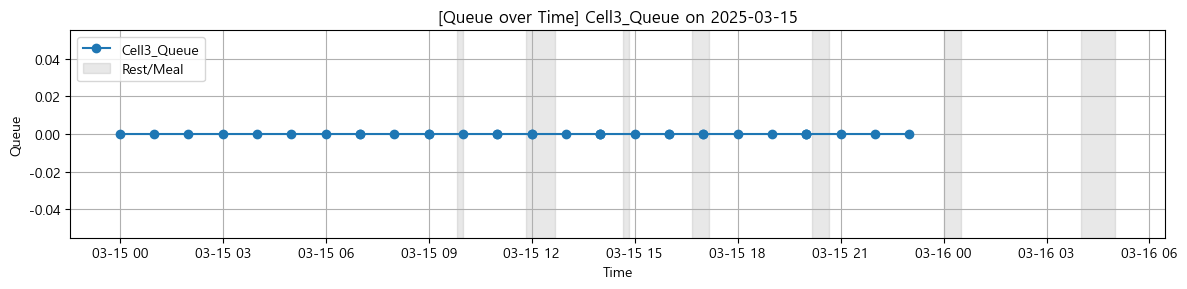

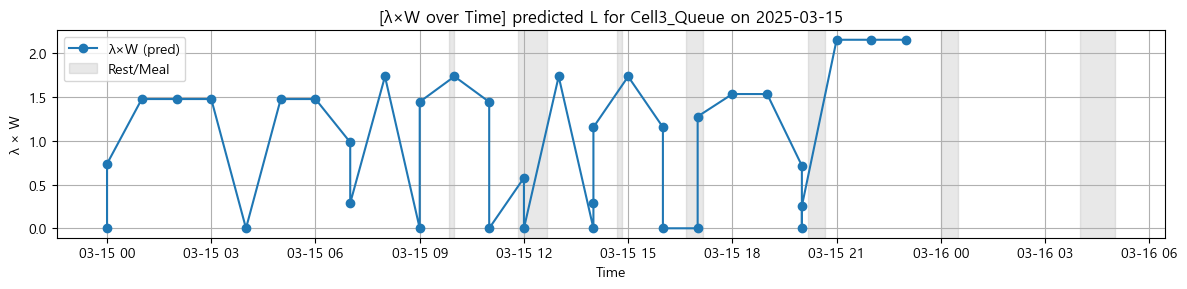

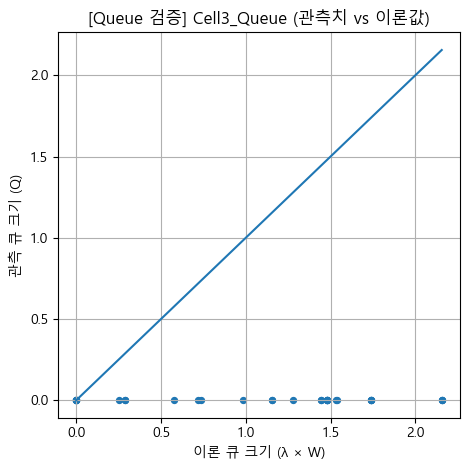

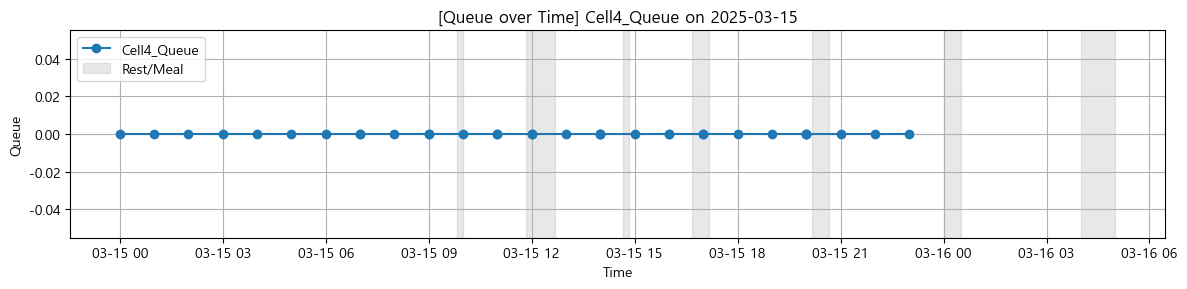

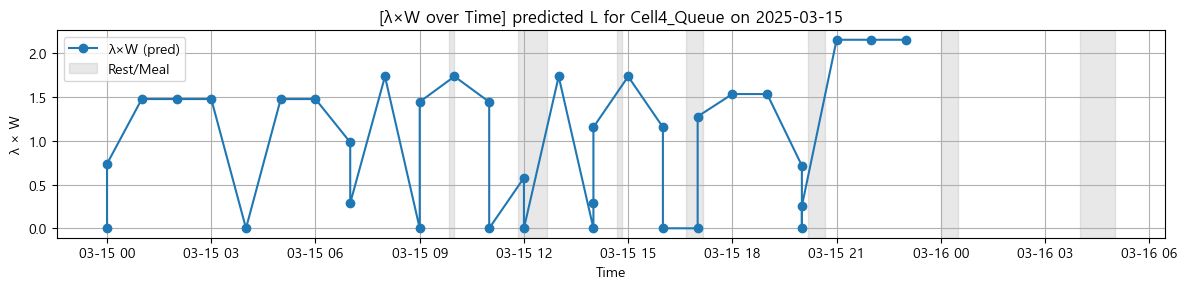

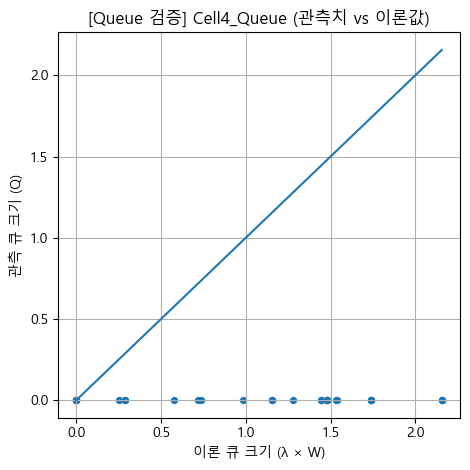

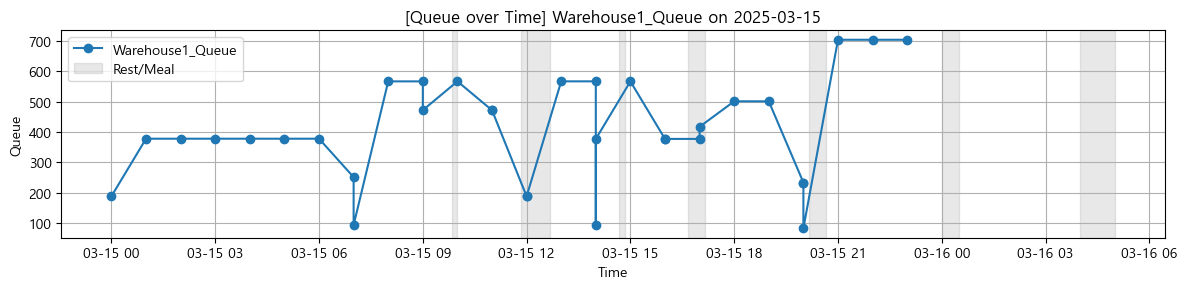

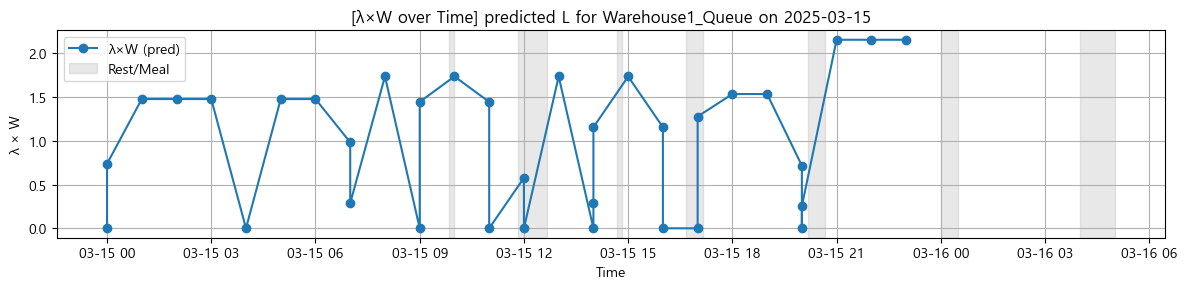

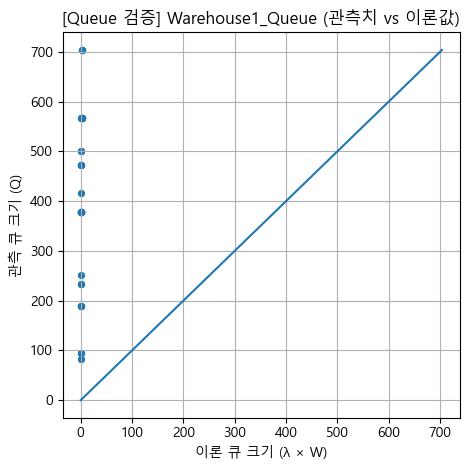

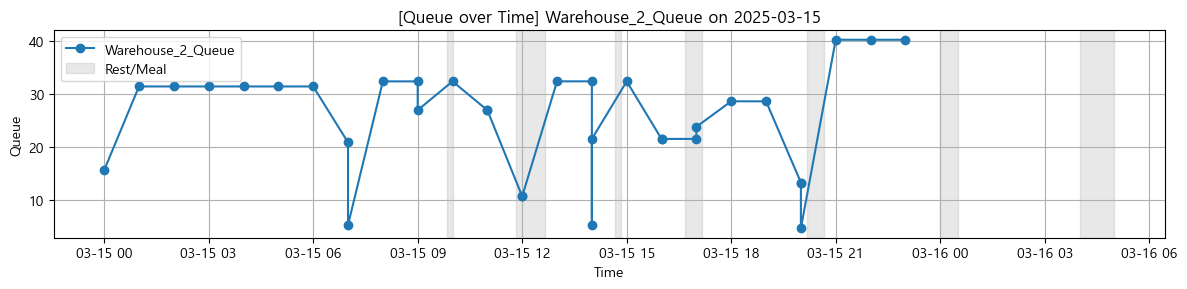

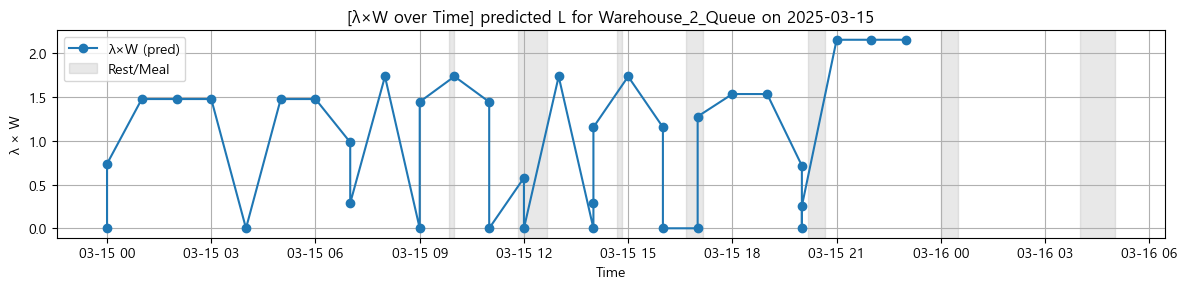

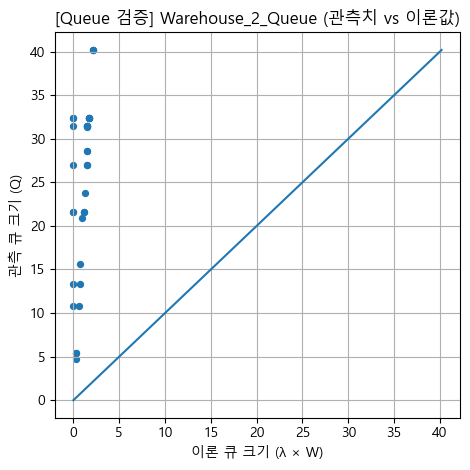

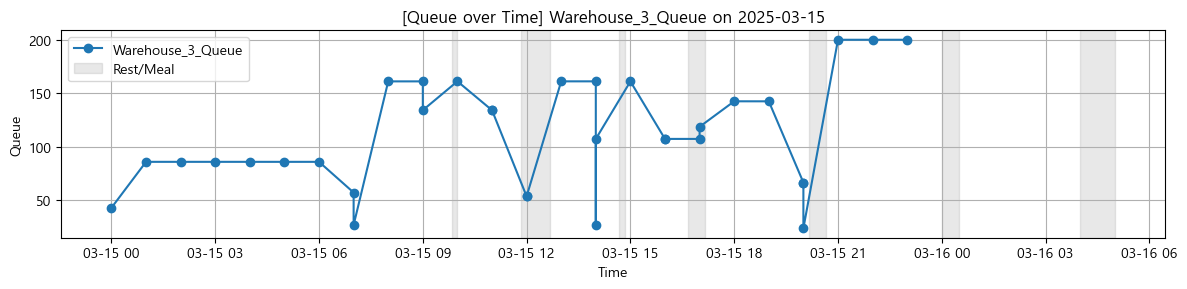

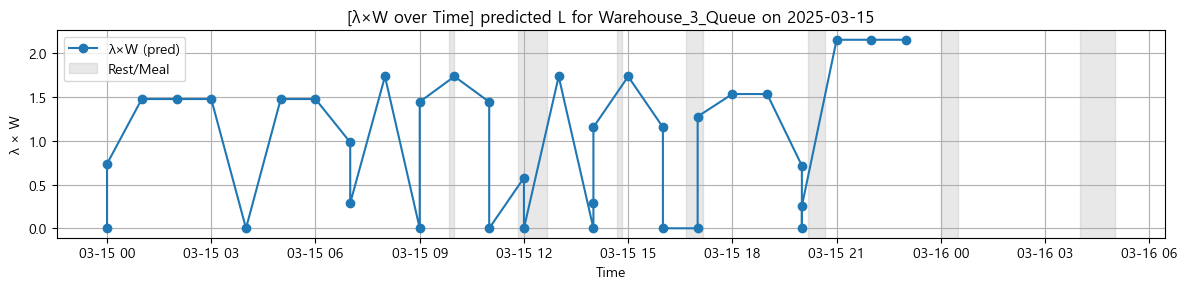

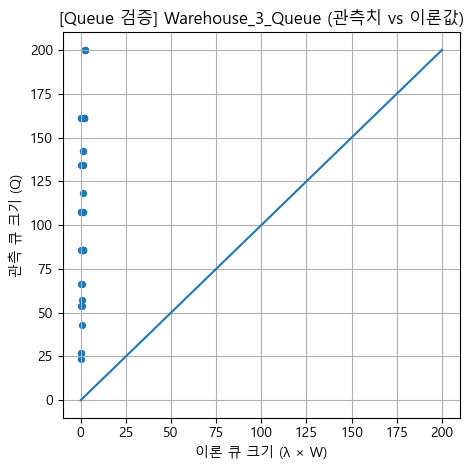

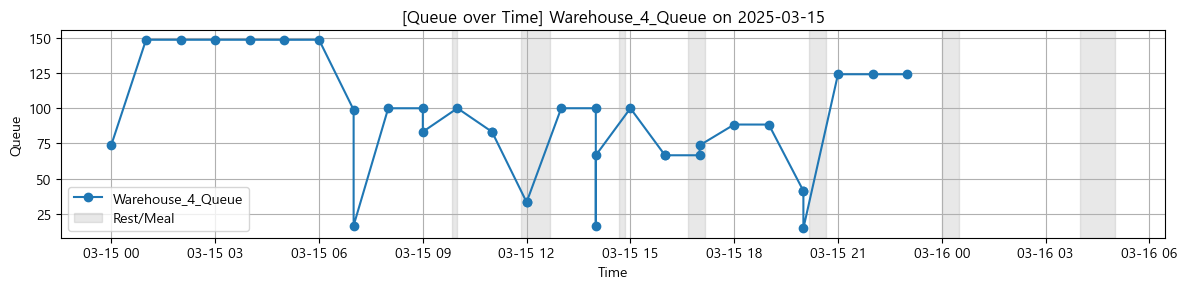

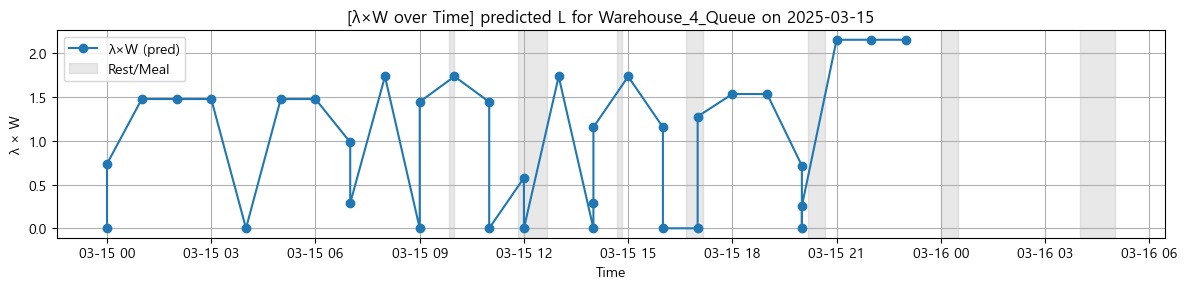

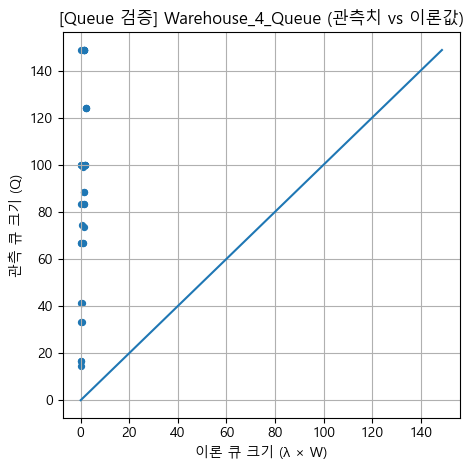

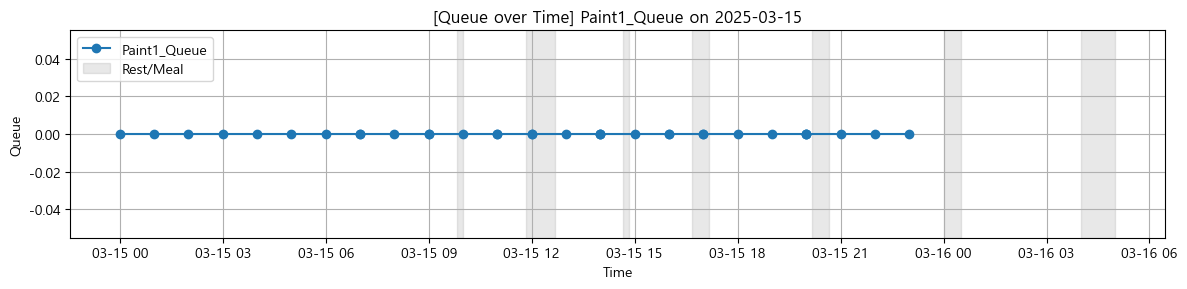

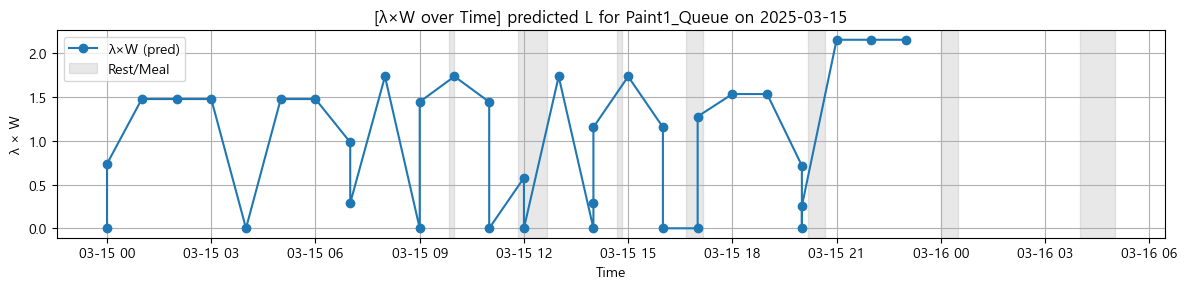

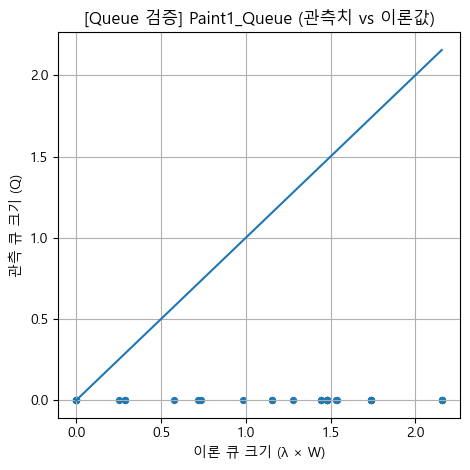

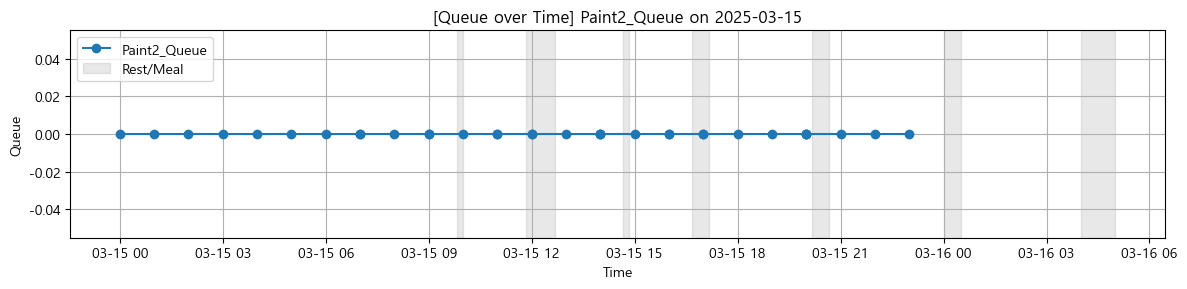

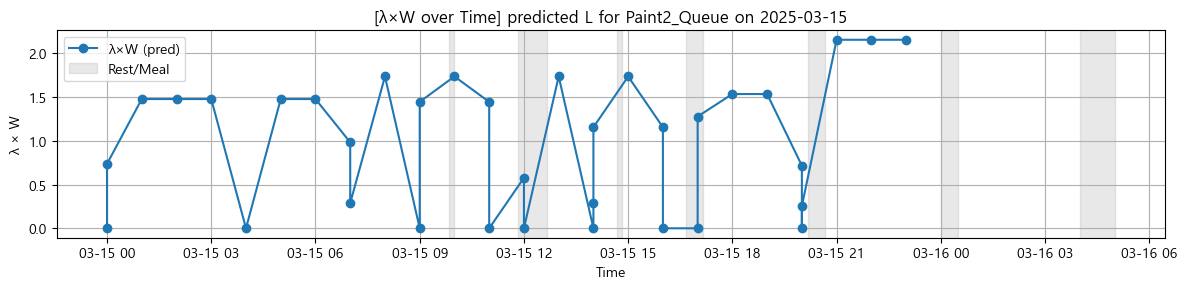

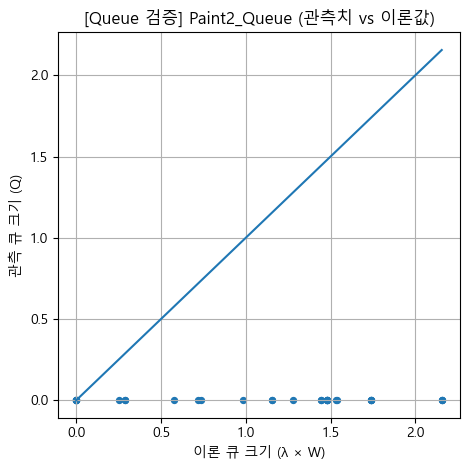

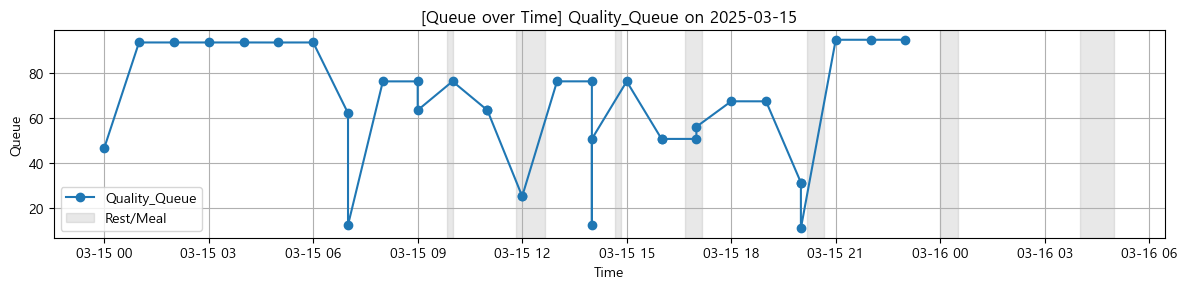

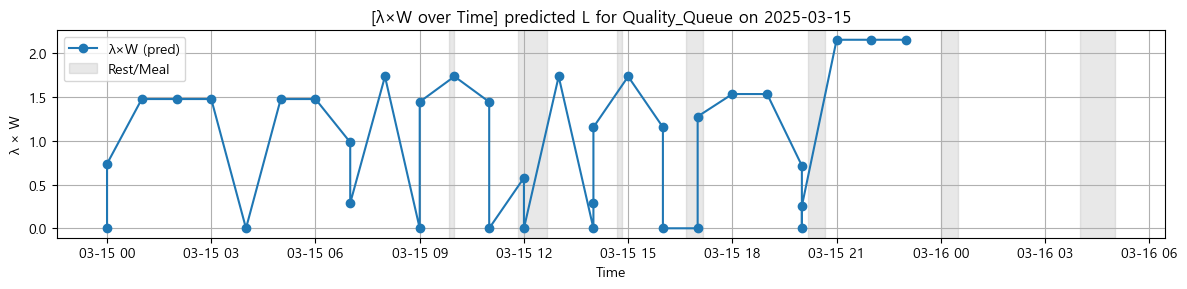

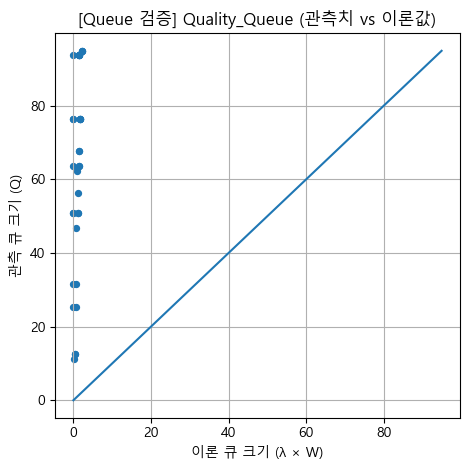

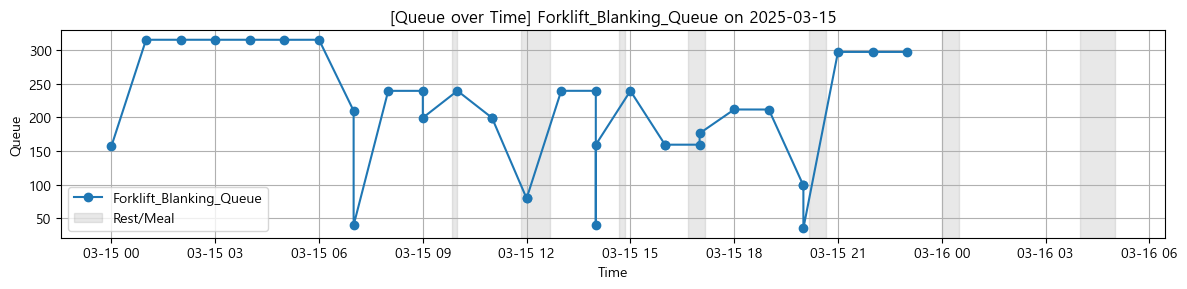

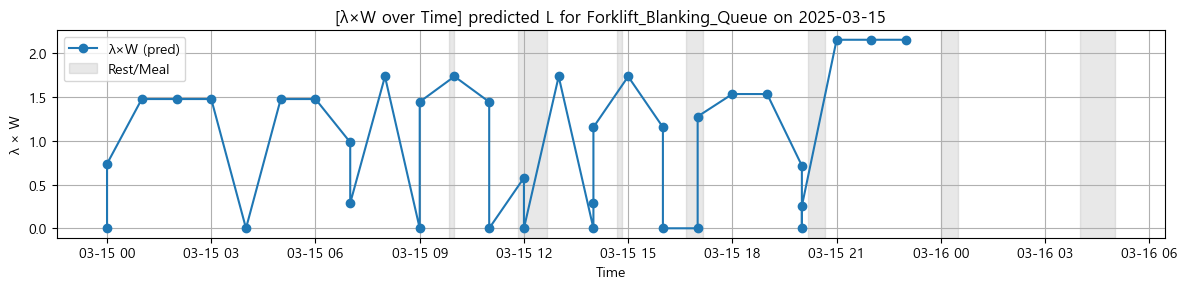

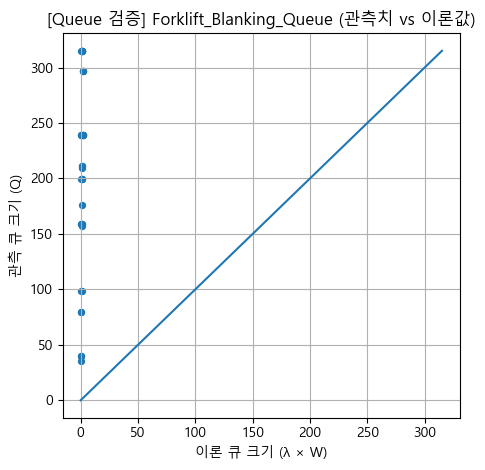

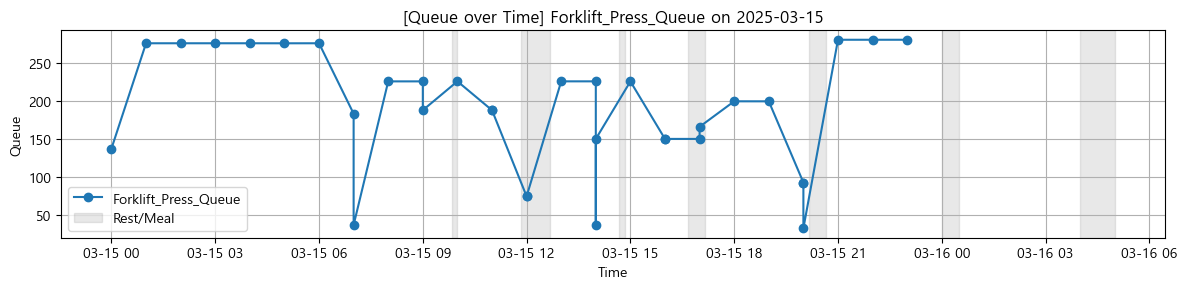

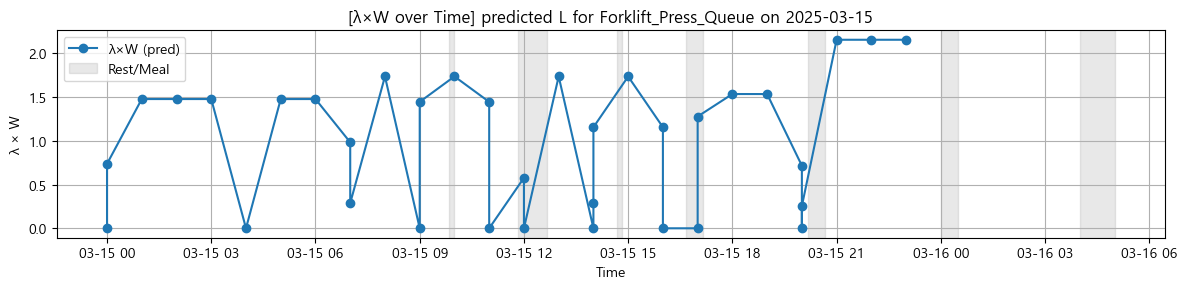

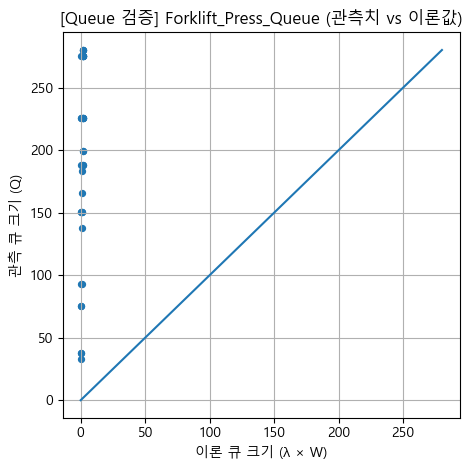

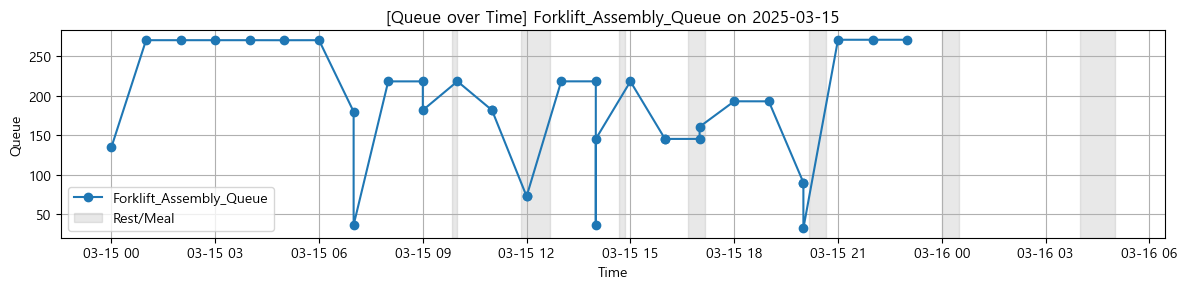

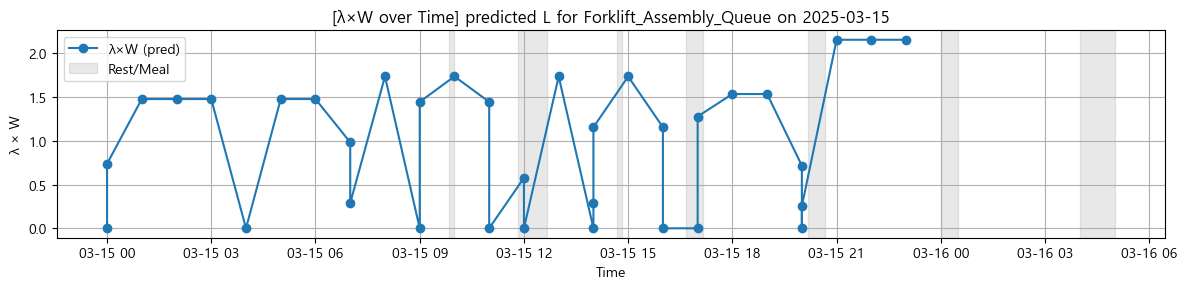

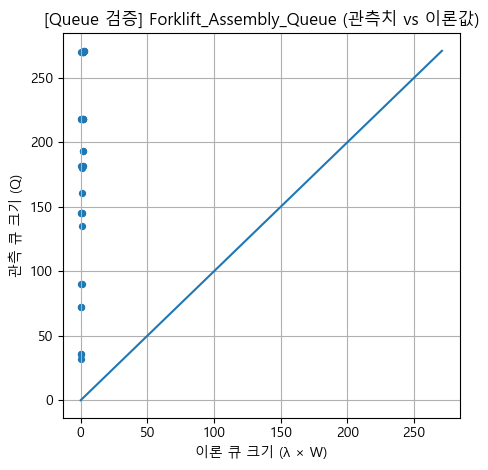

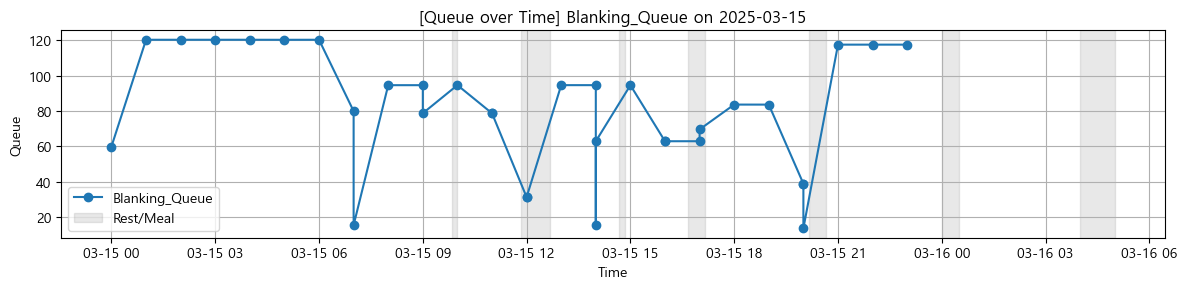

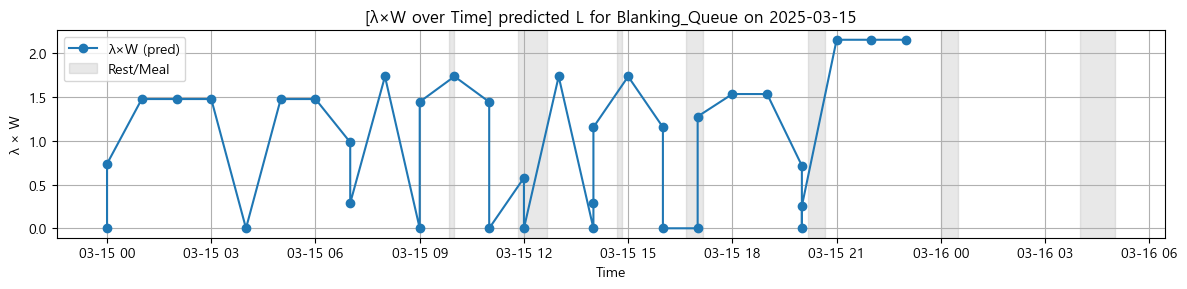

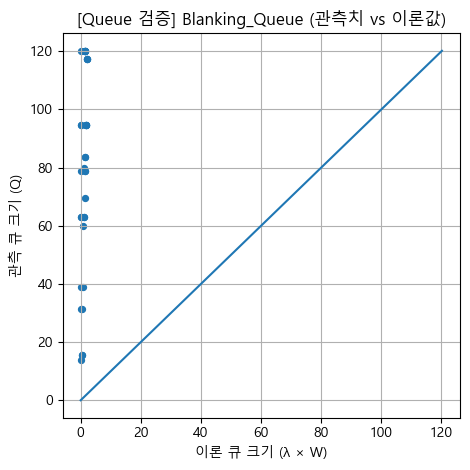

In [26]:
# -*- coding: utf-8 -*-
"""
ÌïòÎ£® ÏÑ†ÌÉù ‚Üí ÏãúÍ∞ÑÎåÄÎ≥Ñ(Ïä¨Î°ØÎ≥Ñ) ÌÅê/ÏÉùÏÇ∞/ÎåÄÍ∏∞ÏãúÍ∞Ñ ÏßÑÎã® ÏãúÍ∞ÅÌôî
- Ìú¥Ïãù/ÏãùÏÇ¨ Íµ¨Í∞Ñ: ÌÅê(Queue) Í∞íÏùÑ 'ÏßÅÏ†Ñ Í∞í Ïú†ÏßÄ(carry-over)' Ï≤òÎ¶¨
- Î∞∞Í≤Ω ÏùåÏòÅ: Ïä§ÏºÄÏ§Ñ Î∏îÎ°ù(Î∂ÄÎ∂Ñ Íµ¨Í∞Ñ) Í∏∞Ï§ÄÏúºÎ°ú Ï†ïÌôïÌûà ÌëúÏãú
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ===== ÏÑ§Ï†ï =====
SLOT_SRC    = "./FinalResults_time_scheduled_20240101_20250630.csv"  # ÏãúÍ∞ÑÎåÄ Î∂ÑÌï¥ Í≤∞Í≥º CSV
TARGET_DATE = "2025-03-15"  # YYYY-MM-DD

# ÏãúÍ∞ÅÌôîÌï† ÌÅê Ïª¨Îüº Î™©Î°ù(Ï°¥Ïû¨ÌïòÎäî Í≤ÉÎßå ÏûêÎèô ÏÇ¨Ïö©Îê®)
QUEUE_COLS = [
    'Blanking_SKU1_Queue','Blanking_SKU2_Queue','Blanking_SKU3_Queue','Blanking_SKU4_Queue',
    'Press1_Queue','Press2_Queue','Press3_Queue','Press4_Queue',
    'Cell1_Queue','Cell2_Queue','Cell3_Queue','Cell4_Queue',
    'Warehouse1_Queue','Warehouse_2_Queue','Warehouse_3_Queue','Warehouse_4_Queue',
    'Paint1_Queue','Paint2_Queue','Quality_Queue',
    'Forklift_Blanking_Queue','Forklift_Press_Queue','Forklift_Assembly_Queue',
    'Blanking_Queue'
]

# === Ïä§ÏºÄÏ§Ñ Ï†ïÏùò (07:50 ~ Îã§ÏùåÎÇ† 07:40 Ï∞Ω) ===
SCHEDULE_BLOCKS = [
    ("07:50","09:50","Ï£ºÍ∞Ñ"),
    ("09:50","10:00","Ìú¥Ïãù"),
    ("10:00","11:50","Ï£ºÍ∞Ñ"),
    ("11:50","12:40","Ï§ëÏãù"),
    ("12:40","14:40","Ï£ºÍ∞Ñ"),
    ("14:40","14:50","Ìú¥Ïãù"),
    ("14:50","16:40","Ï£ºÍ∞Ñ"),
    ("16:40","17:10","ÏÑùÏãù"),
    ("17:10","20:10","ÏûîÏóÖ"),
    ("20:10","20:40","Ìú¥Ïãù"),   # ÍµêÎåÄ
    ("20:40","00:00","ÏïºÍ∞Ñ"),
    ("00:00","00:30","ÏïºÏãù"),   # Îã§ÏùåÎÇ†
    ("00:30","04:00","ÏïºÍ∞Ñ"),   # Îã§ÏùåÎÇ†
    ("04:00","05:00","Ìú¥Ïãù"),   # Îã§ÏùåÎÇ†
    ("05:00","07:40","ÏïºÍ∞Ñ"),   # Îã§ÏùåÎÇ†
]
REST_LABELS = ["Ìú¥Ïãù","Ï§ëÏãù","ÏÑùÏãù","ÏïºÏãù"]

# ===== Îç∞Ïù¥ÌÑ∞ Î°úÎìú/Ï†ÑÏ≤òÎ¶¨ =====
slot = pd.read_csv(SLOT_SRC, low_memory=False)
slot["Time_Now"] = pd.to_datetime(slot["Time_Now"], errors="coerce")
slot["Time_End"] = pd.to_datetime(slot["Time_End"], errors="coerce")
slot["_date"] = slot["Time_Now"].dt.floor("D")

target_day = pd.Timestamp(TARGET_DATE).floor("D")
one = slot[slot["_date"] == target_day].copy().sort_values("Time_Now")
if one.empty:
    raise ValueError(f"{TARGET_DATE} ÎÇ†ÏßúÏùò Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§. TARGET_DATEÎ•º ÌôïÏù∏ÌïòÏÑ∏Ïöî.")

# Ïª¨Îüº Í∑∏Î£π
count_cols = [c for c in one.columns if c.startswith("c_Cell") or c == "c_TotalProducts"]
wait_cols  = [c for c in one.columns if c.endswith("Wait_Time")]

# Ïä¨Î°Ø Í∏∏Ïù¥(Ï¥à)ÏôÄ ÎèÑÏ∞©Î•† Œª
one["slot_seconds"] = (one["Time_End"] - one["Time_Now"]).dt.total_seconds()
one["arrivals_per_sec"] = one[count_cols].sum(axis=1) / one["slot_seconds"].replace(0, np.nan)
one["arrivals_per_sec"] = one["arrivals_per_sec"].fillna(0.0)

# ===== Ìú¥Ïãù/ÏãùÏÇ¨ Íµ¨Í∞Ñ ÌÅê carry-over Ï†ÅÏö© (ÌïòÎ£® ÎÇ¥Î∂Ä forward-fill) =====
rest_mask = one["ShiftLabel"].isin(REST_LABELS)
for qcol in [c for c in QUEUE_COLS if c in one.columns]:
    # Ìú¥Ïãù Íµ¨Í∞ÑÎßå ÏßÅÏ†Ñ Í∞íÏúºÎ°ú Ï±ÑÏõÄ(ÏûëÏóÖ Íµ¨Í∞ÑÏùÄ ÏõêÍ∞í Ïú†ÏßÄ)
    base = one[qcol].where(~rest_mask)      # Ìú¥Ïãù Íµ¨Í∞ÑÏùÑ NaNÏúºÎ°ú
    ffilled = base.ffill()                  # ÏïûÏ™Ω(ÏßÅÏ†Ñ) Í∞íÏúºÎ°ú Î©îÏõÄ
    one.loc[rest_mask, qcol] = ffilled[rest_mask]
    # (ÏÑ†ÌÉù) ÌïòÎ£® Ï≤´ Ïä¨Î°ØÏù¥ Ìú¥ÏãùÏù¥ÎùºÎ©¥ ÏïÑÎûò Ìïú Ï§ÑÎ°ú Îí§Í∞íÏúºÎ°ú Ï±ÑÏö∏ ÏàòÎèÑ ÏûàÏùå
    # one[qcol] = one[qcol].bfill()

# ===== Ïä§ÏºÄÏ§Ñ Í∏∞Î∞ò Ìú¥Ïãù/ÏãùÏÇ¨ Íµ¨Í∞Ñ Í≥ÑÏÇ∞(Î∂ÄÎ∂Ñ Íµ¨Í∞Ñ Ï†ïÌôïÌûà ÏùåÏòÅ) =====
def build_schedule_for_day_for_plot(day: pd.Timestamp) -> pd.DataFrame:
    day = pd.Timestamp(day).floor("D")
    anchor_start = pd.Timestamp(day.year, day.month, day.day, 7, 50)
    anchor_end   = pd.Timestamp(day.year, day.month, day.day, 7, 40) + pd.Timedelta(days=1)
    rows=[]
    for start_str,end_str,label in SCHEDULE_BLOCKS:
        s_h,s_m = map(int,start_str.split(":"))
        e_h,e_m = map(int,end_str.split(":"))
        s = pd.Timestamp(day.year,day.month,day.day,s_h,s_m)
        e = pd.Timestamp(day.year,day.month,day.day,e_h,e_m)
        if (s_h,s_m)<(7,50): s += pd.Timedelta(days=1)              # ÏûêÏ†ï Ïù¥ÌõÑ ‚Üí Îã§ÏùåÎÇ†
        if (e_h,e_m)<(7,50) or e<=s: e += pd.Timedelta(days=1)      # Ï¢ÖÎ£å Î≥¥Ï†ï
        s = max(s, anchor_start); e = min(e, anchor_end)            # Ï∞Ω ÌÅ¥Îû®ÌîÑ
        if e>s: rows.append({"start":s,"end":e,"label":label})
    return pd.DataFrame(rows)

def merge_intervals(df):
    if df.empty: return []
    df=df.sort_values("start").reset_index(drop=True)
    merged=[]; cur_s,cur_e=df.loc[0,"start"],df.loc[0,"end"]
    for i in range(1,len(df)):
        s,e=df.loc[i,"start"],df.loc[i,"end"]
        if s<=cur_e: cur_e=max(cur_e,e)
        else: merged.append((cur_s,cur_e)); cur_s,cur_e=s,e
    merged.append((cur_s,cur_e))
    return merged

def get_rest_intervals_from_schedule(target_day):
    sch = build_schedule_for_day_for_plot(target_day)
    rest = sch[sch["label"].isin(REST_LABELS)][["start","end"]]
    return merge_intervals(rest)

def shade_rest(ax, intervals, label="Rest/Meal"):
    for s,e in intervals: ax.axvspan(s,e,alpha=0.18,color="grey")
    handles,labels=ax.get_legend_handles_labels()
    if label not in labels:
        handles.append(Patch(alpha=0.18,color="grey",label=label))
        ax.legend(handles=handles,loc="best")

# Ï†ïÌôïÌïú(Î∂ÄÎ∂Ñ) Ìú¥Ïãù Íµ¨Í∞Ñ
rest_intervals = get_rest_intervals_from_schedule(target_day)

# ===== 1) ÏãúÍ∞ÑÎåÄÎ≥Ñ ÏÉùÏÇ∞Îüâ(Ï¥ùÌï©) ÎßâÎåÄ + Î∞∞Í≤Ω ÏùåÏòÅ =====
fig, ax = plt.subplots(figsize=(12, 3))
ax.bar(one["Time_Now"], one[count_cols].sum(axis=1))
shade_rest(ax, rest_intervals)
ax.set_title(f"[Counts] Total Production per Slot on {target_day.date()}")
ax.set_xlabel("Time")
ax.set_ylabel("Counts per slot")
ax.grid(True, axis="y")
fig.tight_layout()
plt.show()

# ===== 2) ÌÅê Ïª¨ÎüºÎ≥Ñ ÏãúÍ∞ÅÌôî (Í∞Å Í∑∏ÎûòÌîÑÎßàÎã§ Î∞∞Í≤Ω ÏùåÏòÅ) =====
def sku_from_queue_name(qname: str):
    for p in qname.split("_"):
        if p.startswith("SKU"):
            return p
    return None

for qcol in QUEUE_COLS:
    if qcol not in one.columns:
        print(f"[Ï£ºÏùò] {qcol} Ïª¨ÎüºÏù¥ Ï°¥Ïû¨ÌïòÏßÄ ÏïäÏäµÎãàÎã§. Í±¥ÎÑàÎúÅÎãàÎã§.")
        continue

    # 2-1) ÌÅê ÏãúÍ≥ÑÏó¥
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.plot(one["Time_Now"], one[qcol], marker="o", label=qcol)
    shade_rest(ax, rest_intervals)
    ax.set_title(f"[Queue over Time] {qcol} on {target_day.date()}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Queue")
    ax.grid(True)
    fig.tight_layout()
    plt.show()

    # 2-2) Little's Law Í≤ÄÏ¶ù: Q vs Œª√óW (ÏÑ†ÌÉù)
    # SKUÎ≥Ñ ÎåÄÍ∏∞ÏãúÍ∞Ñ ÏÇ¨Ïö© ‚Üí ÏóÜÏúºÎ©¥ ÌèâÍ∑†/ÌäπÏ†ï SKU fallback
    if (sku := sku_from_queue_name(qcol)) and f"{sku}_Wait_Time" in one.columns:
        W = one[f"{sku}_Wait_Time"].astype(float)
    elif "SKU1_Wait_Time" in one.columns:
        W = one["SKU1_Wait_Time"].astype(float)
    elif wait_cols:
        W = one[wait_cols].mean(axis=1).astype(float)
    else:
        W = pd.Series(np.zeros(len(one)), index=one.index)

    L_pred = one["arrivals_per_sec"] * W

    fig, ax = plt.subplots(figsize=(12, 3))
    ax.plot(one["Time_Now"], L_pred, marker="o", label="Œª√óW (pred)")
    shade_rest(ax, rest_intervals)
    ax.set_title(f"[Œª√óW over Time] predicted L for {qcol} on {target_day.date()}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Œª √ó W")
    ax.grid(True)
    fig.tight_layout()
    plt.show()

    # ÏÇ∞Ï†êÎèÑ: Œª√óW vs Q
    fig, ax = plt.subplots(figsize=(4.8, 4.8))
    ax.scatter(L_pred, one[qcol], s=18)
    m = float(max(L_pred.max(), one[qcol].max()))
    ax.plot([0, m], [0, m])
    ax.set_title(f"[Queue Í≤ÄÏ¶ù] {qcol} (Í¥ÄÏ∏°Ïπò vs Ïù¥Î°†Í∞í)")
    ax.set_xlabel("Ïù¥Î°† ÌÅê ÌÅ¨Í∏∞ (Œª √ó W)")
    ax.set_ylabel("Í¥ÄÏ∏° ÌÅê ÌÅ¨Í∏∞ (Q)")
    ax.grid(True)
    fig.tight_layout()
    plt.show()

## üîé ÌïòÎ£® ÏÉùÏÇ∞/Queue Î∂ÑÏÑù Í≤∞Í≥º ÏöîÏïΩ

- **Ïä§ÏºÄÏ§Ñ Î∞òÏòÅ Ï†ïÏÉÅ**
  - Ìú¥Ïãù/ÏãùÏÇ¨/ÍµêÎåÄ Íµ¨Í∞Ñ ‚Üí ÏÉùÏÇ∞Îüâ **0ÏúºÎ°ú Í∞êÏÜå**
  - QueueÎäî **ÏßÅÏ†Ñ Í∞í Ïú†ÏßÄ(carry-over)** ‚Üí Ïã§Ï†ú ÎåÄÍ∏∞Ïó¥ ÏûîÏ°¥ ÌòÑÏÉÅ Î∞òÏòÅ

- **Queue Ìå®ÌÑ¥**
  - ÏûëÏóÖ Ïû¨Í∞ú Ïãú QueueÍ∞Ä Ï§ÑÏóàÎã§ Îã§Ïãú ÏåìÏù¥Îäî Ìå®ÌÑ¥ ÌôïÏù∏
  - ‚Üí Ïã§Ï†ú Í≥µÏ†ïÏóêÏÑúÏùò **Ï≤òÎ¶¨¬∑Ï†ÅÏ≤¥ Î≥ÄÌôî**Î•º Î∞òÏòÅ

- **Ïù¥Î°†Í∞í(Œª√óW) vs Ïã§Ï†ú Queue**
  - Ìú¥Ïãù Íµ¨Í∞Ñ: Œª=0 ‚Üí Œª√óW=0 (Ïù¥Î°†Í∞í Ï†ïÏÉÅ)
  - Ïã§Ï†ú QÎäî ÏûîÏ°¥ ‚Üí Œª√óWÏôÄ Ï∞®Ïù¥ Î∞úÏÉù
  - ÎåÄÏ≤¥Î°ú Q < Œª√óW ‚Üí **Î™®Ìòï Í≥ºÎåÄÏ∂îÏ†ï Í≤ΩÌñ•**
  - ‚Üí **Î≥ëÎ™©¬∑Ï≤òÎ¶¨ÏÜçÎèÑ Í∞ÄÎ≥ÄÏÑ±¬∑Î™®Îç∏ Îã®ÏàúÌôî ÌïúÍ≥Ñ** Î∂ÑÏÑù Í∞ÄÎä•

- **ÌäπÏ†ï Queue=0 (Ïòà: Cell2_Queue)**
  - ÏÉùÏÇ∞ Î∂ÑÎ∞∞Í∞Ä ÏóÜÎäî Í≥µÏ†ïÏùÄ QueueÎèÑ 0 Ï≤òÎ¶¨
  - ‚Üí Î∂àÌïÑÏöîÌïú Ïû°Ïùå ÏóÜÏù¥ Ïã§Ï†ú Í∞ÄÎèô ÎùºÏù∏Îßå Î∞òÏòÅ

---

‚úÖ **Í≤∞Î°†**:  
- **Ïä§ÏºÄÏ§Ñ/Queue ÎèôÏûë Î°úÏßÅ Ï†ïÏÉÅ Î∞òÏòÅ**  
- **Ïù¥Î°† vs Ïã§Ï†ú Ï∞®Ïù¥**Îäî Ïò§Î•òÍ∞Ä ÏïÑÎãå **Í∞úÏÑ† Ìè¨Ïù∏Ìä∏**  
  ‚Üí Î≥ëÎ™© ÏßÑÎã® Î∞è Î™®Îç∏ Í≥†ÎèÑÌôî ÏßÄÌëúÎ°ú ÌôúÏö© Í∞ÄÎä•


FinalResults_time_scheduled_20240101_20250630.csv